# Actividad 1: Trabajando con redes neuronales y Deep Learning

## Regresión

<p style='color:gray'> Óscar Jiménez Osuna - Enero 2021</p>

In [85]:
%config IPCompleter.greedy=True
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

Se proporcionan los datos de alquiler de bicicletas por horas de los años 2011 y 2012. Vamos a buscar modelos en los que exista una mejor correlación entre atributos independientes y nuestra variable dependiente que en este caso es el número total de bicicletas alquiladas. Es decir, queremos saber de qué dependerá que se alquilen más o menos bicicletas.

**Campos de datos**

- *datetime:* fecha y hora.
- *time:* hora.
- *season:*
    - 1 = invierno
    - 2 = primavera
    - 3 = verano
    - 4 = otoño 
- *holiday:* si el día es considerado festivo.
    - 0 = no
    - 1 = si
- *workingday:* si el día es o no laborable o fin de semana.
    - 0 = no
    - 1 = si
- *weather:* 
    - 1: despejado, pocos Nubes, Parcialmente nublado, Parcialmente nublado.
    - 2: Niebla + Nublado, Niebla + Nubes rotas, Niebla + Pocas nubes, Niebla.
    - 3: Nieve ligera, Lluvia ligera + Tormenta + Nubes dispersas, Lluvia ligera + Nubes dispersas.
    - 4: Lluvia intensa + hielo + tormenta + niebla, nieve + neblina.  
- *temp:* temperatura en grados Celsius.
- *atemp:* sensación de fría - temperatura en grados Celsius.
- *humidity:* humedad relativa.
- *windspeed:* velocidad del viento.
- *dayOfWeek:* día de la semana.
    - dinsdag = lunes
    - woensdag = martes
    - donderdag = miércoles
    - maandag = jueves
    - vrijdag = viernes
    - zaterdag = sábado
    - zondag = domingo
- *count:* número de alquileres totales.

*Descarga dataset: https://www.openml.org/d/1414*

### Exploración analítica de los datos.

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import tensorflow as tf
from tensorflow import keras
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
import pathlib
from tensorflow.keras import layers
from keras import backend as K
from time import time
import warnings
warnings.filterwarnings('ignore')

Abrimos nuestro dataset eliminando las comillas de todas las columnas y observamos las variables que aparecen con el método head() para verificarlas.

In [87]:
url="https://www.openml.org/data/get_csv/1796712/php6pI1Nq"
df = pd.read_csv(url, quotechar="'", )
# Eliminamos las comillas de las cabeceras.
df.columns = df.columns.str.replace('"','')
# Traducimos los días de la semana
df = df.replace({"dinsdag":"lunes","woensdag":"martes","donderdag":"miércoles","maandag":"jueves","vrijdag":"viernes","zaterdag":"sábado",
                "zondag":"domingo"})
df.head()

,datetime,time,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,dayOfWeek
0,2011-01-01 00:00:00,00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,sábado
1,2011-01-01 01:00:00,01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,sábado
2,2011-01-01 02:00:00,02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,sábado
3,2011-01-01 03:00:00,03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,sábado
4,2011-01-01 04:00:00,04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,sábado


Realizamos una primera vista de los datos con una visualización general.

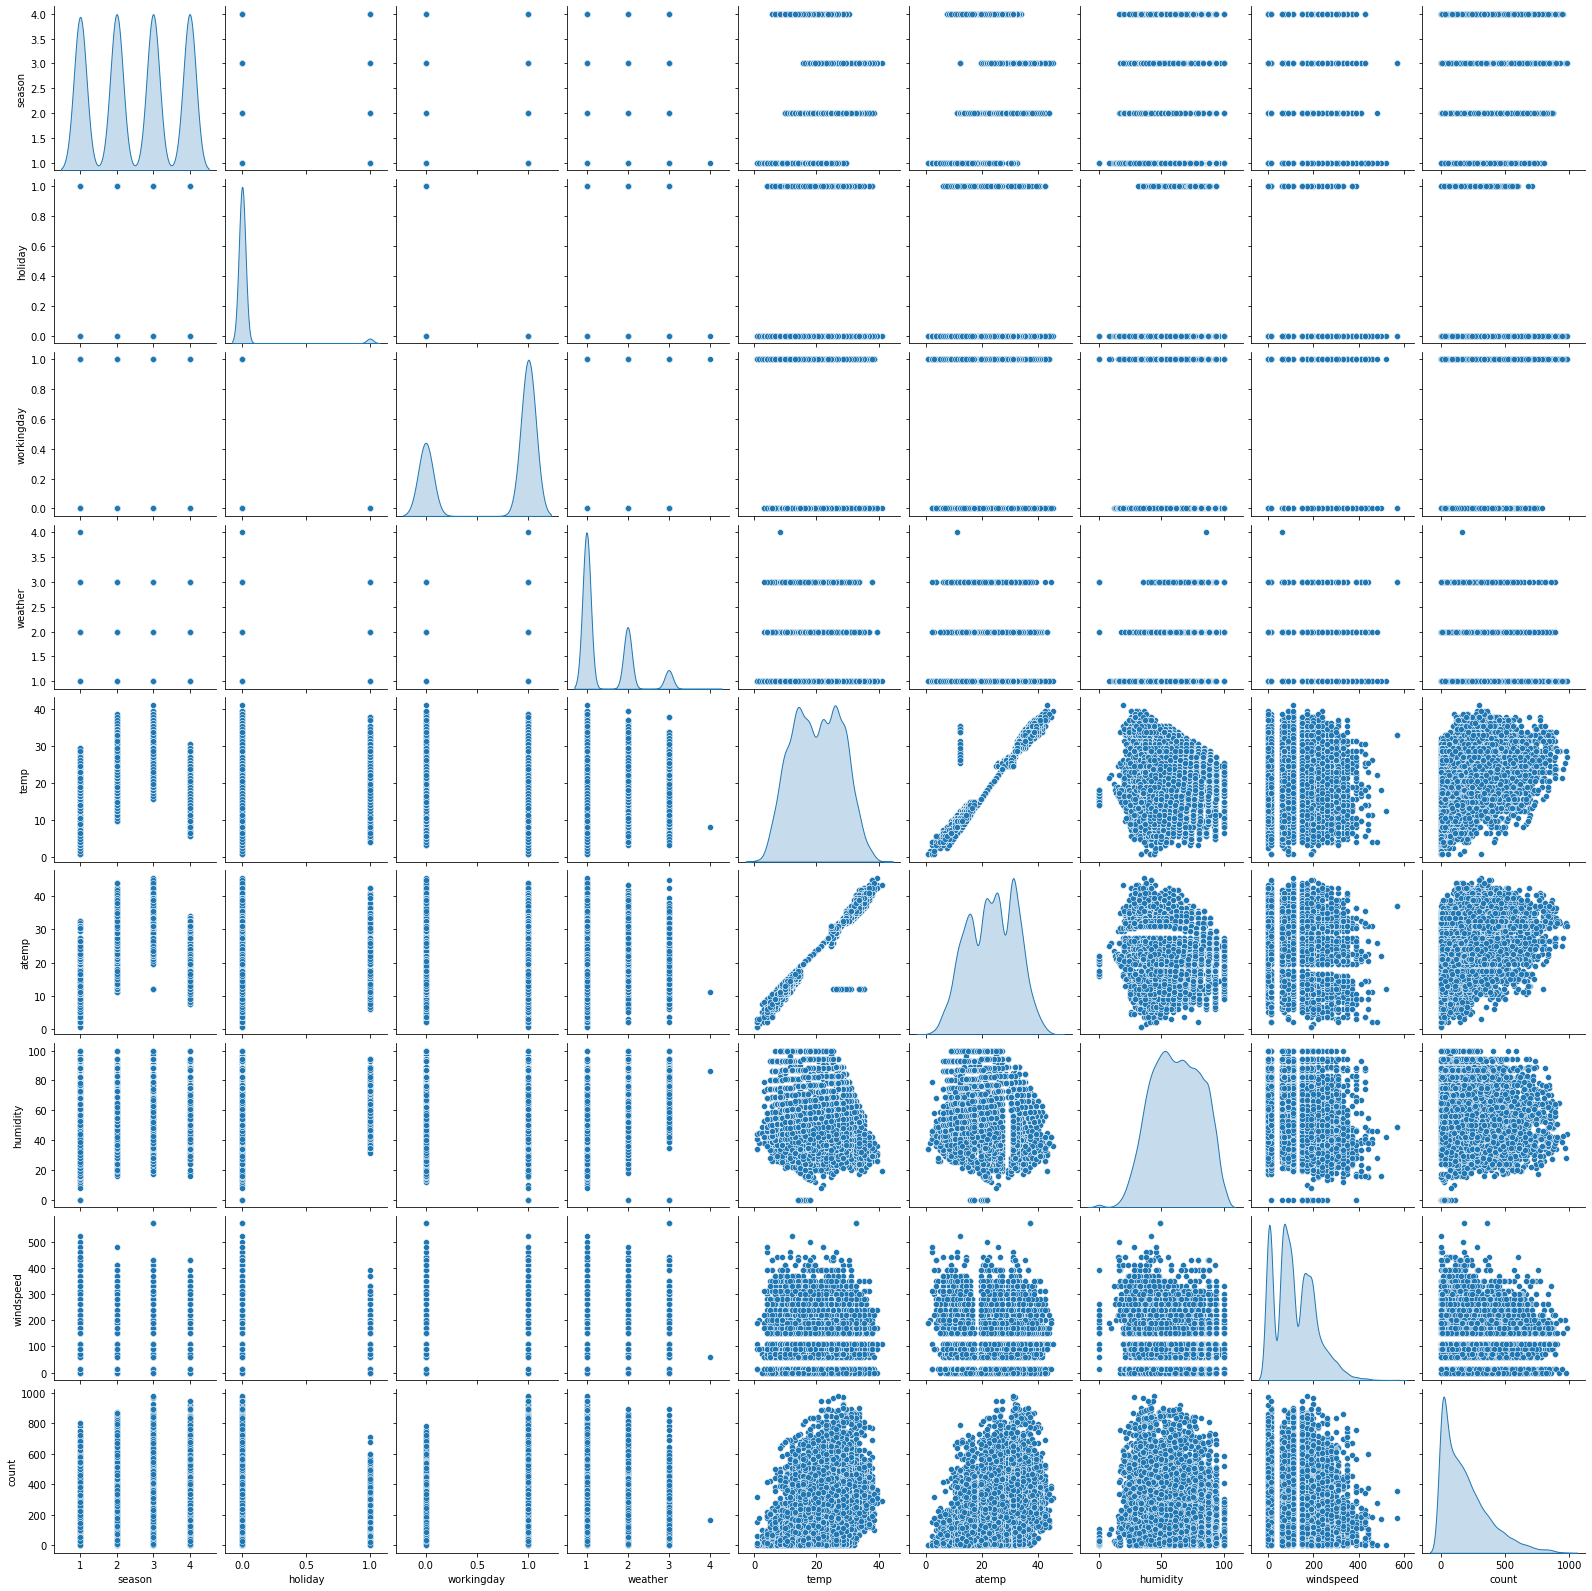

In [88]:
sns.pairplot(df[['dayOfWeek', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'count']], diag_kind="kde")

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   time        10886 non-null  object 
 2   season      10886 non-null  int64  
 3   holiday     10886 non-null  int64  
 4   workingday  10886 non-null  int64  
 5   weather     10886 non-null  int64  
 6   temp        10886 non-null  float64
 7   atemp       10886 non-null  float64
 8   humidity    10886 non-null  int64  
 9   windspeed   10886 non-null  float64
 10  count       10886 non-null  int64  
 11  dayOfWeek   10886 non-null  object 
dtypes: float64(3), int64(6), object(3)
memory usage: 1020.7+ KB


El dataset tienen 10886 instancias, 11 atributos y 1 atributo objetivo ('count')

Verificamos qué columnas, nulos y tipo de datos tenemos. El conjunto de datos es una mezcla de números enteros, flotantes y valores textuales y no hay valores nulos.

Vamos a desagrupar la columna datetime en año, mes, dia, hora y día de la semana y cambiar el formato de humidity a float

In [90]:
df['datetime']=df['datetime'].astype('datetime64')
df['Year']=df['datetime'].dt.year
df['Month']=df['datetime'].dt.month
df['Day']=df['datetime'].dt.day
df['Hour']=df['datetime'].dt.hour
df['humidity']=df['humidity'].astype('float')

In [91]:
df.head()

,datetime,time,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,dayOfWeek,Year,Month,Day,Hour
0,2011-01-01 00:00:00,00:00:00,1,0,0,1,9.84,14.395,81.0,0.0,16,sábado,2011,1,1,0
1,2011-01-01 01:00:00,01:00:00,1,0,0,1,9.02,13.635,80.0,0.0,40,sábado,2011,1,1,1
2,2011-01-01 02:00:00,02:00:00,1,0,0,1,9.02,13.635,80.0,0.0,32,sábado,2011,1,1,2
3,2011-01-01 03:00:00,03:00:00,1,0,0,1,9.84,14.395,75.0,0.0,13,sábado,2011,1,1,3
4,2011-01-01 04:00:00,04:00:00,1,0,0,1,9.84,14.395,75.0,0.0,1,sábado,2011,1,1,4


Cambio al último lugar la columna de la variable objetivo 'count'

In [92]:
cols = df.columns.values.tolist()
df = df[['dayOfWeek','Year','Month','Day','Hour', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'count']]
df.head()

,dayOfWeek,Year,Month,Day,Hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,sábado,2011,1,1,0,1,0,0,1,9.84,14.395,81.0,0.0,16
1,sábado,2011,1,1,1,1,0,0,1,9.02,13.635,80.0,0.0,40
2,sábado,2011,1,1,2,1,0,0,1,9.02,13.635,80.0,0.0,32
3,sábado,2011,1,1,3,1,0,0,1,9.84,14.395,75.0,0.0,13
4,sábado,2011,1,1,4,1,0,0,1,9.84,14.395,75.0,0.0,1


Descripción estadística de los datos numéricos

In [93]:
df.describe()

,Year,Month,Day,Hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2011.501929,6.521495,9.992559,11.541613,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,116.796522,191.574132
std,0.500019,3.444373,5.476608,6.915838,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,88.352193,181.144454
min,2011.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,1.000000
25%,2011.000000,4.000000,5.000000,6.000000,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,60.032000,42.000000
50%,2012.000000,7.000000,10.000000,12.000000,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,110.014000,145.000000
75%,2012.000000,10.000000,15.000000,18.000000,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,169.979000,284.000000
max,2012.000000,12.000000,19.000000,23.000000,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,569.969000,977.000000


Observamos en la tabla de estadísticos lo siguiente:

- Todas las variables tienes 10886 instancias
- La estación en la que más se alquilan bicicletas, de media es entre primavera y verano con una desviación de una estación, es decir, entre mediados del invierno y mediados del verano.
- Confirmamos que la media de 'holiday' es prácticamente 0, lo que nos indica que se alquilan más bicicletas cuando no es un día festivo existiendo poca desviación en este dato.
- Para 'Workingday' tenemos una media más cercana a 1 que significa que hay más alquileres en días laborables teniendo una desviación del casi 0.5 puntos.
- Respecto a 'weather', la media nos confirma que la mayoría de alquileres se realizan en dias despejados o muy poco nublado con una desviación que no nos llega a llevar a valores de días con nieve o lluvia.
- La temperatura media en la que se realizan alquileres es de 20ºC con un +/- de casi 8ºC y un 'atemp' de 23.65ºC +/- 0.76ºC. Además, podemos ver que existe un 25% de los alquiles se han dado con temperaturas hasta 13.94ºC, el siguiente 25% hasta el 50% hasta temperaturas de 20.5ºC, el siguiente 25% hasta el 75% hasta temperaturas de 26.24ºC, teniendo además un caso de alquiler con temperatura mínima de 0.82ºC y otro con máxima de 41ºC
- La humedad media cuando se hay alquileres de bicicletas es 61.88 g/m3 con desviaciones de hasta 19.24 g/m3.
- La velocidad media del viento es de 116.79 m/s.
- La media de alquileres por hora es 191.57 existiendo una desviación de +/-181.14 con un mínimo de 1 alquiler en una hora y un máximo de 977 alquileres en una hora determinada.

Verifiquemos si hay correlación entre los datos

In [94]:
corr = df.set_index("Day").corr()
print("R de Pearson:")
corr

R de Pearson:


,Year,Month,Hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
Year,1.000000,-0.004932,-0.004234,-0.004797,0.012021,-0.002482,-0.012548,0.061226,0.058540,-0.078606,-0.019415,0.260403
Month,-0.004932,1.000000,-0.006818,0.971524,0.001731,-0.003394,0.012144,0.257589,0.264173,0.204537,-0.138600,0.166862
Hour,-0.004234,-0.006818,1.000000,-0.006546,-0.000354,0.002780,-0.022740,0.145430,0.140343,-0.278011,0.128982,0.400601
season,-0.004797,0.971524,-0.006546,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.136946,0.163439
holiday,0.012021,0.001731,-0.000354,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.009792,-0.005393
workingday,-0.002482,-0.003394,0.002780,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.010133,0.011594
weather,-0.012548,0.012144,-0.022740,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.003640,-0.128655
temp,0.061226,0.257589,0.145430,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.027877,0.394454
atemp,0.058540,0.264173,0.140343,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.064170,0.389784
humidity,-0.078606,0.204537,-0.278011,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.295479,-0.317371


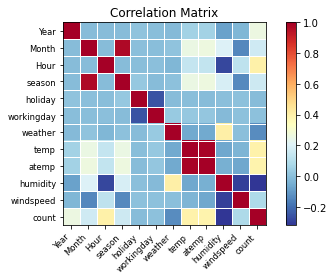

<Figure size 2880x1440 with 0 Axes>

In [95]:
sm.graphics.plot_corr(corr, xnames=list(corr.columns))
plt.figure(figsize=(40,20))
plt.show()

No se observa gran correlacion con entre nuestro atributo clase y el resto de atributos.

Modifico los nombres de los valores de las instancias para una representación gráfica general más clara de todas las variables.

In [96]:
df_relations = df.copy()

df_relations.Month = df_relations.Month.replace({1: "Enero", 2: "Febrero", 3: "Marzo", 4: "Abril", 5: "Mayo", 6: "Junio", 7: "Julio", 8: "Agosto", 9: "Septiembre", 
                                 10: "Octubre", 11: "Noviembre", 12: "Diciembre"})
df_relations.season = df_relations.season.replace({1: "Invierno", 2: "Primavera", 3: "Verano", 4: "Otoño"})
df_relations.holiday = df_relations.holiday.replace({0: "Trabajo", 1: "Vacaciones"})
df_relations.workingday = df_relations.workingday.replace({0: "Festivo", 1: "Laborable"})
df_relations.weather = df_relations.weather.replace({1: "Despejado", 2: "Nublado", 3: "Lluvia ligera", 4: "Muy lluvioso"})

df_relations.head()

,dayOfWeek,Year,Month,Day,Hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,sábado,2011,Enero,1,0,Invierno,Trabajo,Festivo,Despejado,9.84,14.395,81.0,0.0,16
1,sábado,2011,Enero,1,1,Invierno,Trabajo,Festivo,Despejado,9.02,13.635,80.0,0.0,40
2,sábado,2011,Enero,1,2,Invierno,Trabajo,Festivo,Despejado,9.02,13.635,80.0,0.0,32
3,sábado,2011,Enero,1,3,Invierno,Trabajo,Festivo,Despejado,9.84,14.395,75.0,0.0,13
4,sábado,2011,Enero,1,4,Invierno,Trabajo,Festivo,Despejado,9.84,14.395,75.0,0.0,1


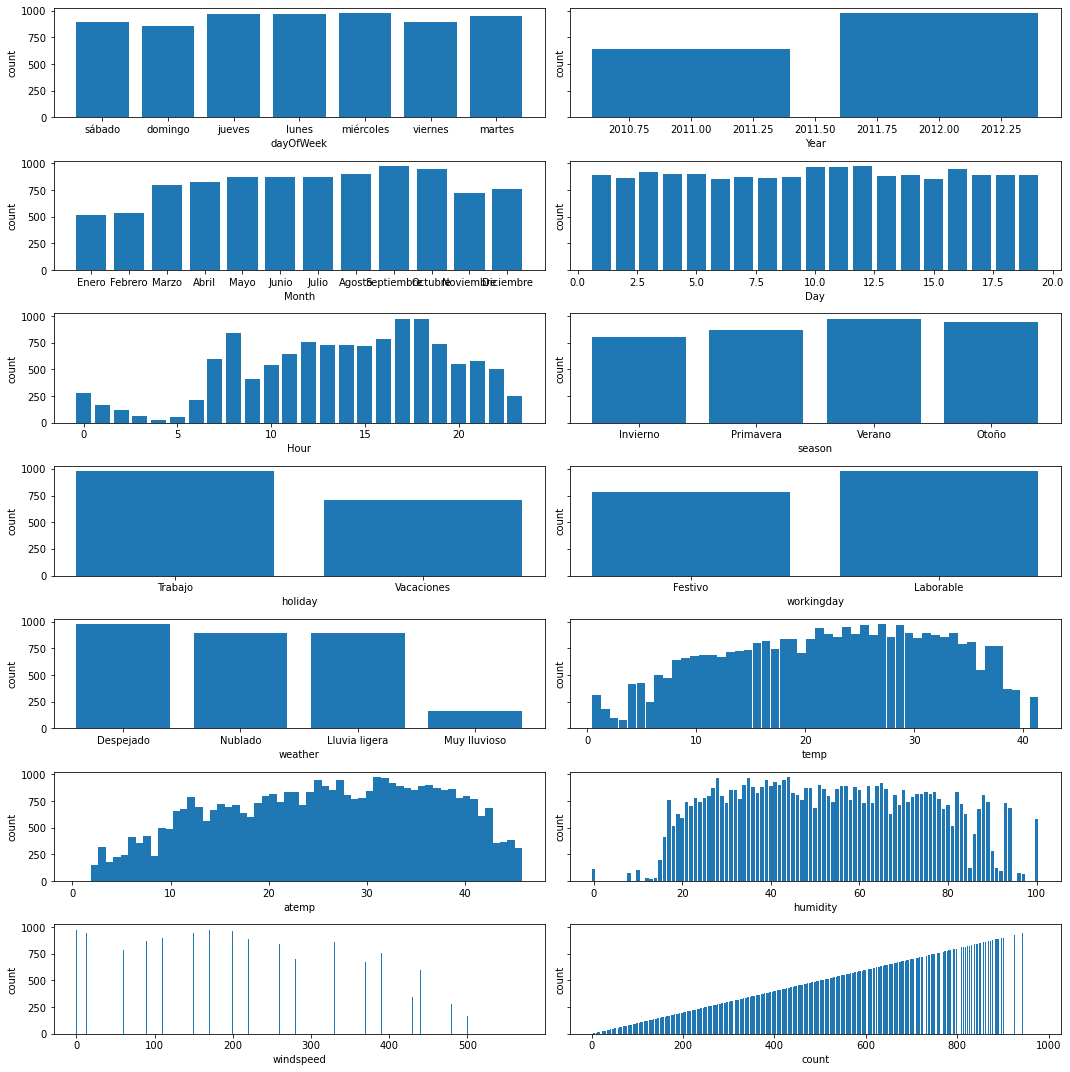

In [97]:
columns_names = df_relations.columns.values

fig, axs = plt.subplots(7, 2, tight_layout=True,figsize=(15,15),sharey=True)
i=0
j=0
k=0
for i in range(7):
    for j in range(2):
        if k>13:
            break
        df_year = df_relations.groupby(by = columns_names[k]).sum()       
        axs[i,j].bar(df_relations[columns_names[k]], df_relations['count'])
        axs[i,j].set_xlabel(columns_names[k])
        axs[i,j].set_ylabel("count")     
        j+=1
        k+=1       
    j = 0 
    i+=1
    
plt.show()

Observamos que hay mayor alquiler de bicicletas:

- Los lunes, miércoles y jueves.
- En el año 2012.
- El mes de septiembre.
- En las horas 17h00 y 18h00.
- En verano.
- Lo días laborables.
- Cuando hace buen tiempo.
- Cuando las temperaturas son en torno a los 20-30ºC
- Cuando la humedad es del 25-40 g/m3
- Cuando el viento está en entre los 0-160 m/s

Estos datos los podemos representarlos graficamente en un diagrama de cajas y bigotes:

<Figure size 432x288 with 0 Axes>

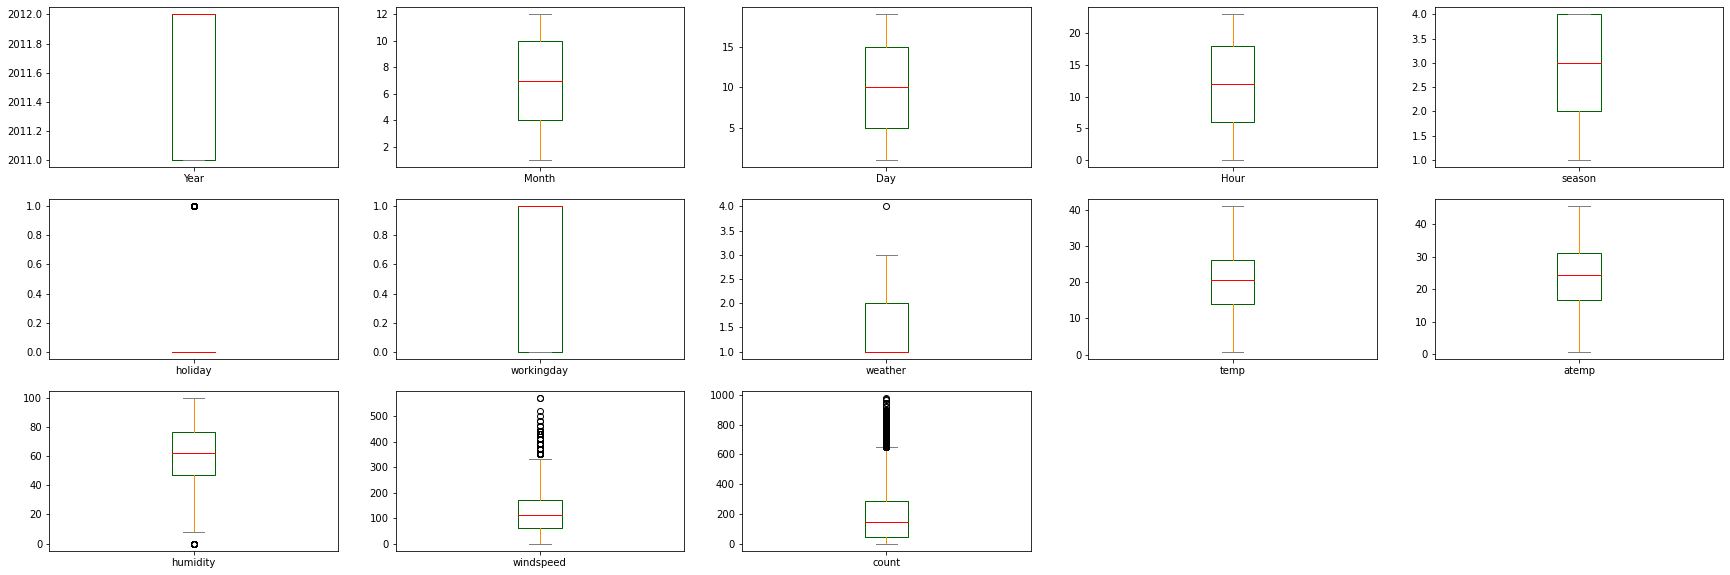

In [98]:
color = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='Red', caps='Gray')
plt.figure()
df.plot(kind = "box", subplots = True, layout = (3,5), sharex = False, sharey = False,figsize=(30,10), color=color)
plt.show()

### Variables numéricas

Vamos a verificar graficamente la correlación de las variables independientes continuas "temp","atemp","humidity","windspeed" con la variable dependiente con un modelo de regresión lineal simple.

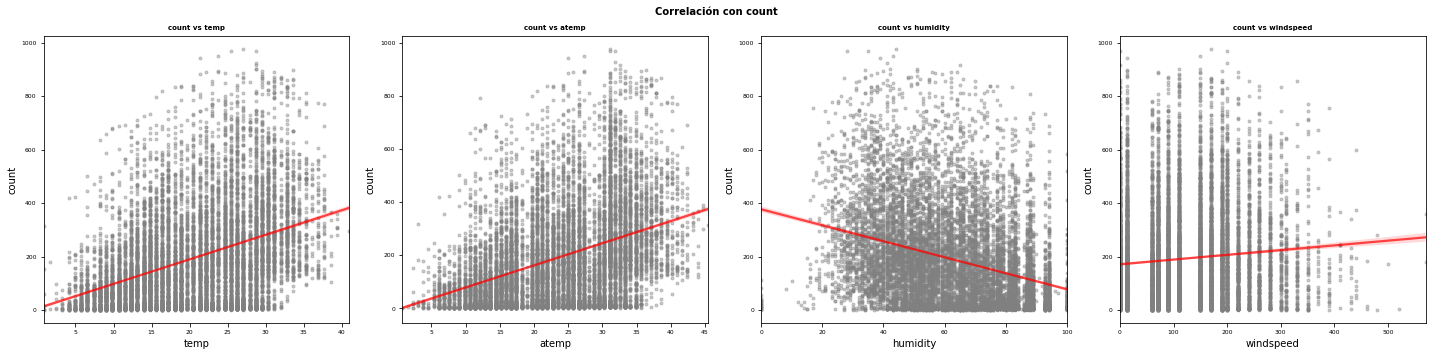

In [99]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
axes = axes.flat
columnas_numeric = df.select_dtypes(include=['float64', 'int']).columns

for i, colum in enumerate(columnas_numeric):
    sns.regplot(x = df[colum], y = df['count'], color = "gray", marker = '.', scatter_kws = {"alpha":0.4}, line_kws = {"color":"r","alpha":0.7}, ax = axes[i])
    axes[i].set_title(f"count vs {colum}", fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel(colum)
    axes[i].set_ylabel("count")
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Correlación con count', fontsize = 10, fontweight = "bold");

Hay mucha dispersión en los datos pero podemos obervar que cuando la temperatura o la sensación calor aumenta hasta entorno los 30ºC se alquilan más bicicletas y vemos que la correlación es positiva.

En el caso de la humeda ocurre lo contrario, la correlación es negativa alquilandose menos bicicletas a medida que hay más humedad. 

La correlación en el caso del viento es positiva pero con menor pendiente, pero se ve claramente viendo la gráfica que hay menor alquiler de bicicletas cuando más viento hace.

La conclusión, a primera vista, es que no hay una buena correlación lineal con ninguna de las variables. Vamos a verlo con números.

In [100]:
# factorizamos la columna dayOfWeek
df["dayOfWeek"] = df["dayOfWeek"].map({"lunes":1, "martes":2, "miércoles":3, "jueves":4, "viernes":5, "sábado":6, "domingo":7})
df.head(5)

,dayOfWeek,Year,Month,Day,Hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,6,2011,1,1,0,1,0,0,1,9.84,14.395,81.0,0.0,16
1,6,2011,1,1,1,1,0,0,1,9.02,13.635,80.0,0.0,40
2,6,2011,1,1,2,1,0,0,1,9.02,13.635,80.0,0.0,32
3,6,2011,1,1,3,1,0,0,1,9.84,14.395,75.0,0.0,13
4,6,2011,1,1,4,1,0,0,1,9.84,14.395,75.0,0.0,1


In [101]:
# vamos a quedarnos solo con las variables 'datetime','time', 'season', 'holiday', workingday', 'weather' y 'dayOfWeek'
# Creamos una copia del dataset
df_copy = df
df = df.drop(['Month', 'Day', 'Hour'], axis='columns')

In [102]:
column_names = df.columns.values.tolist()

In [103]:
df["dayOfWeek"].unique()

array([6, 7, 4, 1, 3, 5, 2], dtype=int64)

Creamos las variables dummy necesarias.

In [104]:
season_dummy = pd.get_dummies(df["season"], prefix="season")
holiday_dummy = pd.get_dummies(df["holiday"], prefix="holiday")
workingday_dummy = pd.get_dummies(df["workingday"], prefix="seaworkingdayson")
weather_dummy = pd.get_dummies(df["weather"], prefix="weather")
dayOfWeek_dummy = pd.get_dummies(df["dayOfWeek"], prefix="dayOfWeek")

Creamos un nuevo dataset con las columnas de las variables dummy necesarias y eliminamos las columnas que no nos harán falta ('datetime','time', 'season', 'holiday', workingday', 'weather' y 'dayOfWeek')

In [105]:
df_new = df[column_names].join([season_dummy, holiday_dummy, workingday_dummy, weather_dummy, dayOfWeek_dummy])

In [106]:
df_new = df_new.reindex(columns=['temp','atemp','humidity','windspeed','season_1','season_2','season_3','season_4','holiday_0','holiday_1','seaworkingdayson_0',
 'seaworkingdayson_1','weather_1','weather_2','weather_3','weather_4','dayOfWeek_1','dayOfWeek_2','dayOfWeek_3','dayOfWeek_4','dayOfWeek_5','dayOfWeek_6',
                                 'dayOfWeek_7','count'])
df_new.head(2)

,temp,atemp,humidity,windspeed,season_1,season_2,season_3,season_4,holiday_0,holiday_1,...,weather_3,weather_4,dayOfWeek_1,dayOfWeek_2,dayOfWeek_3,dayOfWeek_4,dayOfWeek_5,dayOfWeek_6,dayOfWeek_7,count
0,9.84,14.395,81.0,0.0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,16
1,9.02,13.635,80.0,0.0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,40


### Regresión Lineal Múltiple

Vamos a realizar varios modelos con los siguientes atributos independientes:

    - 'temp','atemp','humidity','windspeed'
    - 'temp','atemp','humidity','windspeed','season_1','season_2','season_3','season_4','holiday_0','holiday_1'
    - 'temp','atemp','humidity','windspeed','season_1','season_2','season_3','season_4','seaworkingdayson_0', 'seaworkingdayson_1'
    - 'temp','atemp','humidity','windspeed','season_1','season_2','season_3','season_4','weather_1','weather_2','weather_3','weather_4'
    - 'temp','atemp','humidity','windspeed','season_1','season_2','season_3','season_4','dayOfWeek_1','dayOfWeek_2','dayOfWeek_3','dayOfWeek_4','dayOfWeek_5','dayOfWeek_6','dayOfWeek_7'
    
Crearemos también unos gráficos de distribución para evaluar visualmente los modelos.

Atributos de la función: ['temp', 'atemp', 'humidity', 'windspeed', 'count']


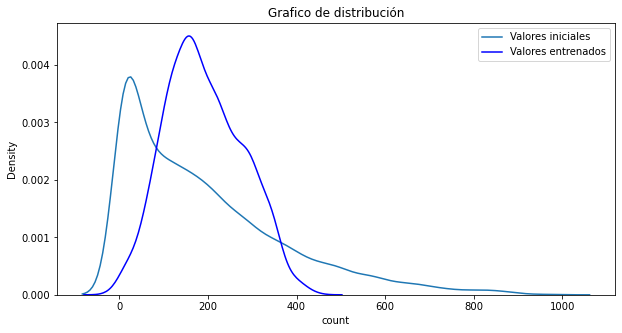

R2 entrenamiento: 24.38
R2 prueba: 24.08
Mean squared error: 24613.73
--------------------------------------------------------------------------------------------------------------------------------------------------------------------

Atributos de la función: ['temp', 'humidity', 'windspeed', 'count']


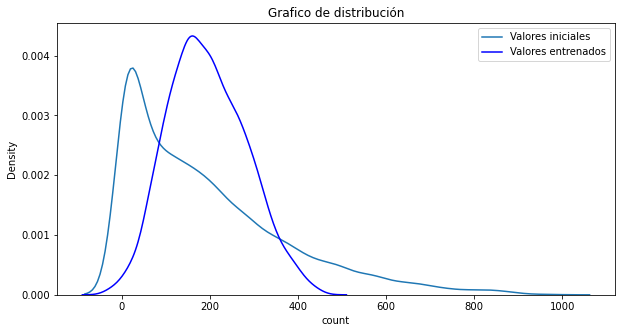

R2 entrenamiento: 23.88
R2 prueba: 25.00
Mean squared error: 24669.21
--------------------------------------------------------------------------------------------------------------------------------------------------------------------

Atributos de la función: ['temp', 'atemp', 'windspeed', 'count']


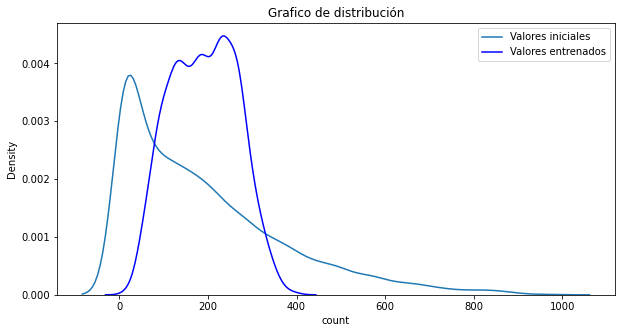

R2 entrenamiento: 16.46
R2 prueba: 16.88
Mean squared error: 28192.56
--------------------------------------------------------------------------------------------------------------------------------------------------------------------

Atributos de la función: ['temp', 'atemp', 'humidity', 'count']


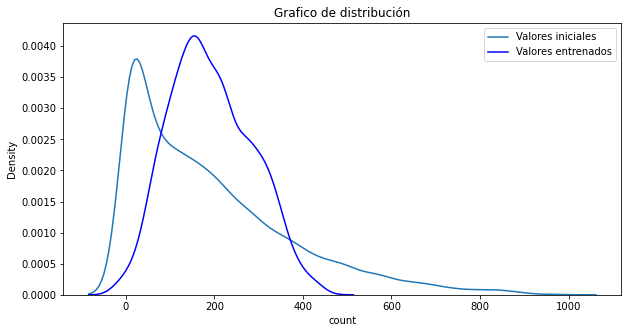

R2 entrenamiento: 24.42
R2 prueba: 23.73
Mean squared error: 24804.50
--------------------------------------------------------------------------------------------------------------------------------------------------------------------



In [107]:
feature_columns_1 = ['temp','atemp','humidity','windspeed','count']
feature_columns_2 = ['temp','humidity','windspeed','count']
feature_columns_3 = ['temp','atemp','windspeed','count']
feature_columns_4 = ['temp','atemp','humidity','count']

feature_columns = [feature_columns_1, feature_columns_2, feature_columns_3, feature_columns_4]

R2_train = list()
R2_test = list()
MSE = list()

for i in feature_columns:
    dfb = df_new.reindex(columns=i)    
    x = dfb.drop(['count'], axis=1)
    y = dfb["count"] 
    # Separo los datos en entrenamiento y prueba para probar los algoritmos en una proporción (80-20)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
    # Defino el algoritmo a utilizar y lo entreno
    lin_reg= LinearRegression().fit(x_train,y_train)
    
    # Realizo una predicción
    y_pred= lin_reg.predict(x_test)

    print("Atributos de la función:",i)  
    fig, ax = plt.subplots(figsize =(10,5))
    sns.kdeplot(df["count"], ax=ax)
    sns.kdeplot(y_pred, color ="b", ax=ax)
    plt.title("Grafico de distribución")
    plt.legend(("Valores iniciales", "Valores entrenados"))
    plt.show()

    # Calculamos el error
    print("R2 entrenamiento: %.2f" %(lin_reg.score(x_train, y_train)*100))
    print("R2 prueba: %.2f" % (lin_reg.score(x_test, y_test)*100))
    print('Mean squared error: %.2f' % (mean_squared_error(y_test, y_pred)))
    R2_train.append(lin_reg.score(x_train, y_train)*100)
    R2_test.append(lin_reg.score(x_test, y_test)*100)
    MSE.append(mean_squared_error(y_test, y_pred))
    
    print("--------------------------------------------------------------------------------------------------------------------------------------------------------------------\n")

Vemos que si ponemos el parámetro fit_intercept=False el model empeora.

In [108]:
df_resultados = pd.DataFrame({'Atributos':feature_columns,'R2_train':R2_train,'R2_test':R2_test, 'MSE':MSE}, )
df_resultados

,Atributos,R2_train,R2_test,MSE
0,"[temp, atemp, humidity, windspeed, count]",24.378871,24.082811,24613.727374
1,"[temp, humidity, windspeed, count]",23.884753,25.001077,24669.205171
2,"[temp, atemp, windspeed, count]",16.462214,16.884088,28192.558289
3,"[temp, atemp, humidity, count]",24.418070,23.726017,24804.500573


Atributos de la función: ['temp', 'atemp', 'humidity', 'windspeed', 'count']


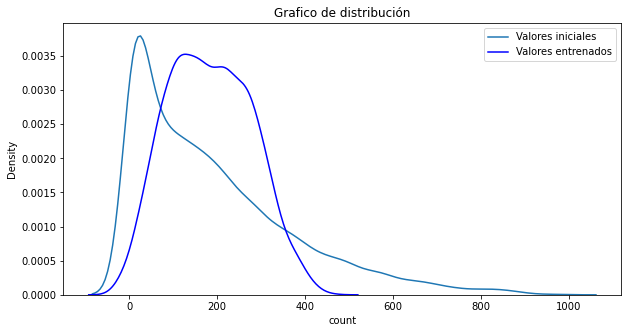

R2 entrenamiento: 20.78
R2 prueba: 22.76
Mean squared error: 25111.13
--------------------------------------------------------------------------------------------------------------------------------------------------------------------

Atributos de la función: ['temp', 'humidity', 'windspeed', 'count']


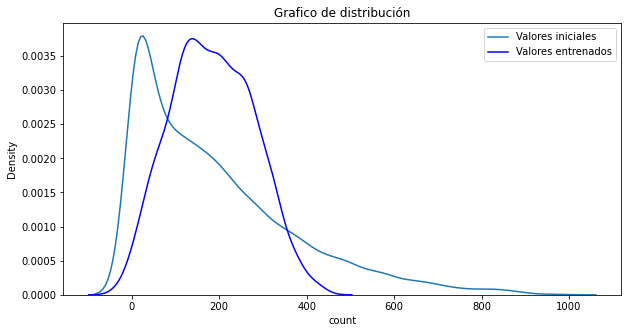

R2 entrenamiento: 19.92
R2 prueba: 21.37
Mean squared error: 26767.45
--------------------------------------------------------------------------------------------------------------------------------------------------------------------

Atributos de la función: ['temp', 'atemp', 'windspeed', 'count']


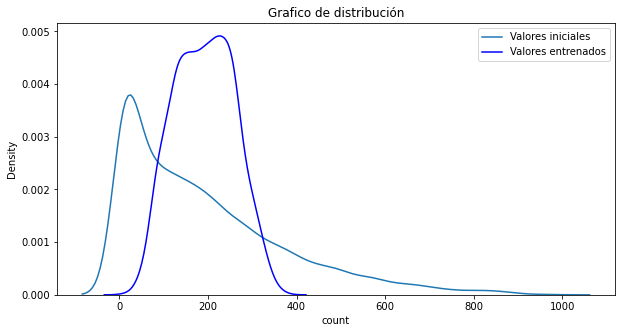

R2 entrenamiento: 16.60
R2 prueba: 15.51
Mean squared error: 27010.56
--------------------------------------------------------------------------------------------------------------------------------------------------------------------

Atributos de la función: ['temp', 'atemp', 'humidity', 'count']


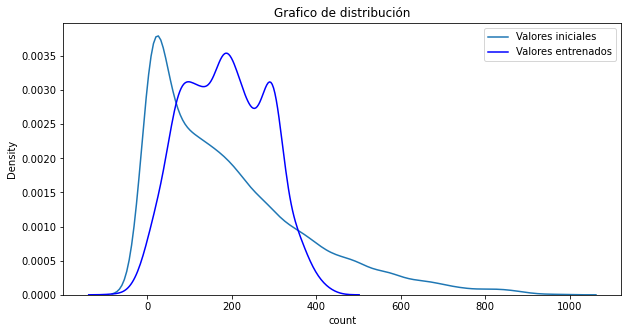

R2 entrenamiento: 19.21
R2 prueba: 20.49
Mean squared error: 26605.40
--------------------------------------------------------------------------------------------------------------------------------------------------------------------



In [109]:
R2_train = list()
R2_test = list()
MSE = list()

for i in feature_columns:
    dfb = df_new.reindex(columns=i)    
    x = dfb.drop(['count'], axis=1)
    y = dfb["count"] 
    # Separo los datos en entrenamiento y prueba para probar los algoritmos en una proporción (80-20)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
    # Defino el algoritmo a utilizar y lo entreno
    lin_reg= LinearRegression(fit_intercept=False).fit(x_train,y_train)
  
    # Realizo una predicción
    y_pred= lin_reg.predict(x_test)

    print("Atributos de la función:",i)  
    fig, ax = plt.subplots(figsize =(10,5))
    sns.kdeplot(df["count"], ax=ax)
    sns.kdeplot(y_pred, color ="b", ax=ax)
    plt.title("Grafico de distribución")
    plt.legend(("Valores iniciales", "Valores entrenados"))
    plt.show()

    # Calculamos el error
    print("R2 entrenamiento: %.2f" %(lin_reg.score(x_train, y_train)*100))
    print("R2 prueba: %.2f" % (lin_reg.score(x_test, y_test)*100))
    print('Mean squared error: %.2f' % (mean_squared_error(y_test, y_pred)))
    R2_train.append(lin_reg.score(x_train, y_train)*100)
    R2_test.append(lin_reg.score(x_test, y_test)*100)
    MSE.append(mean_squared_error(y_test, y_pred))
    
    print("--------------------------------------------------------------------------------------------------------------------------------------------------------------------\n")

In [110]:
df_resultados = pd.DataFrame({'Atributos':feature_columns,'R2_train':R2_train,'R2_test':R2_test, 'MSE':MSE}, )
df_resultados

,Atributos,R2_train,R2_test,MSE
0,"[temp, atemp, humidity, windspeed, count]",20.779512,22.757354,25111.132156
1,"[temp, humidity, windspeed, count]",19.915340,21.365836,26767.449762
2,"[temp, atemp, windspeed, count]",16.598271,15.514719,27010.558642
3,"[temp, atemp, humidity, count]",19.212440,20.490317,26605.396150


Podemos observar que tenemos en todos los casos el valor de R2 tanto para el entrenamiento como para la prueba no se acerca a 1 con lo que los distintos modelos no ajustan bien y podemos confirmar lo que ya vimos más arriba. No existe una gran correlación de los atributos dados a que se alquilen más o menos bicicletas. Solo mejora un poco al eliminar una de las variables que estaban muy correlacionadas ('temp', 'atemp')
El error medio cuadrado tan grande nos confirma el gran error existente entre los datos reales y los predichos. 
De hecho,si graficamos de nuevo las rectas de regresión lo veremos. Vamos a comparar la recta de regresión ahora con los valores de prueba (x_test e y_test).Vemos que sale igual que como ya se graficó más arriba.

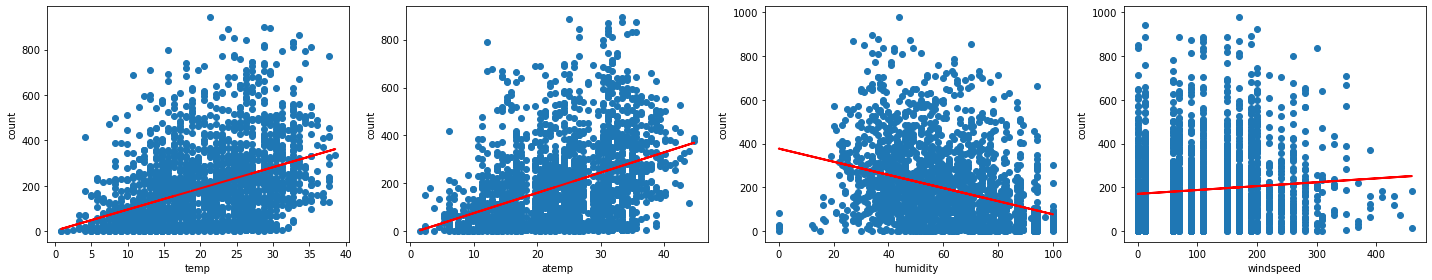

In [111]:
atributos = ["temp","atemp","humidity","windspeed"]

fig, axs = plt.subplots(1, 4, tight_layout=True,figsize=(20,4),sharey=False)
i=0

for atr in atributos: 
    x = df[atr].array
    y = df["count"].array    
    x = x.to_numpy(dtype=object)
    x = x.reshape(-1, 1)
    y.to_numpy(dtype=object)
    # Separo los datos en entrenamiento y prueba para probar los algoritmos en una proporción (80-20)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
    # Defino el algoritmo a utilizar y lo entreno
    lm= LinearRegression().fit(x_train,y_train)
    # Realizo una predicción
    y_pred= lm.predict(x_test)
    
    axs[i].scatter(x_test,y_test)
    axs[i].plot(x_test, y_pred, color='red', linewidth=2)
    plt.setp(axs[i], xlabel=atributos[i], ylabel = "count")
    i +=1
plt.show()

### Clasificador de perceptrón multicapa

In [112]:
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import StratifiedKFold 
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

In [113]:
# dividimos el dataset en entrenamiento y test pasando antes el dataset a formato array
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
df_transformed = ss.fit_transform(df)
df_transformed
X = df_transformed[:, 0:9]
y = df_transformed[:, 9]
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=1, shuffle = True)

In [115]:
model = MLPRegressor()

parametros = {
    'hidden_layer_sizes':((5, 3),(15, 10)),
    'activation': ('identity', 'relu', 'tanh', 'logistic'),
    'solver': ('lbfgs','sgd', 'adam'),
    'learning_rate': ('constant', 'invscaling', 'adaptive')}

clf = GridSearchCV(estimator=model, scoring=['neg_mean_squared_error', 'r2'], param_grid=parametros, cv = 5, refit='r2')
tic = time()
clf.fit(X_train, y_train)
clf.predict(X_validation)
result = clf.predict(X_validation)
print(f"done in {time() - tic:.3f}s")

done in 1095.207s


In [116]:
# podemos ver los resultados de todos los modelos creados
resultados = pd.DataFrame(clf.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_hidden_layer_sizes,param_learning_rate,param_solver,params,split0_test_neg_mean_squared_error,...,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2
0,0.142113,0.137871,0.005996,0.007505,identity,"(5, 3)",constant,lbfgs,"{'activation': 'identity', 'hidden_layer_sizes...",-0.886000,...,0.035670,49,0.145655,0.138352,0.136488,0.142523,0.132229,0.139050,0.004675,49
1,2.323626,0.633201,0.002399,0.000799,identity,"(5, 3)",constant,sgd,"{'activation': 'identity', 'hidden_layer_sizes...",-0.884874,...,0.032389,57,0.146741,0.132172,0.132818,0.107960,0.136019,0.131142,0.012715,57
2,2.361746,0.611111,0.001999,0.000631,identity,"(5, 3)",constant,adam,"{'activation': 'identity', 'hidden_layer_sizes...",-0.884043,...,0.035733,45,0.147542,0.137070,0.135821,0.140181,0.134829,0.139088,0.004595,44
3,0.089744,0.051098,0.001399,0.000490,identity,"(5, 3)",invscaling,lbfgs,"{'activation': 'identity', 'hidden_layer_sizes...",-0.885993,...,0.035668,51,0.145662,0.138347,0.136497,0.142518,0.132205,0.139046,0.004682,51
4,2.078327,0.995765,0.001799,0.000977,identity,"(5, 3)",invscaling,sgd,"{'activation': 'identity', 'hidden_layer_sizes...",-1.126100,...,0.093673,70,-0.085866,-0.107217,-0.072070,-0.341111,-0.057515,-0.132756,0.105458,70


Mejor puntuación: 36.29
Mejores parámetros: {'activation': 'tanh', 'hidden_layer_sizes': (15, 10), 'learning_rate': 'adaptive', 'solver': 'lbfgs'}


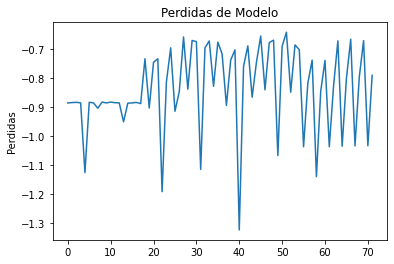

In [117]:
print("Mejor puntuación: %0.2f" % (100*clf.best_score_))
print("Mejores parámetros:", clf.best_params_)
prediccion= clf.predict(X_validation)
plt.figure(1)
plt.plot((clf.cv_results_["split0_test_neg_mean_squared_error"]))
# plt.plot(prediccion, alpha=0.1)
plt.title('Perdidas de Modelo')
plt.ylabel('Perdidas')
plt.show()

### Red neuronal Keras

In [118]:
from keras.layers import Dense,Input
from keras.models import Sequential,Model
from keras.optimizers import SGD,Adam

In [119]:
x = df.drop(['count'], axis=1)
y = df["count"] 
# Separo los datos en entrenamiento y prueba para probar los algoritmos en una proporción (80-20)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [120]:
# Normalizado y escalado
# Restaremos la media y dividiremos entre la desviación tipica
mean = X_train.mean(axis=0) # media de nuestro set de entrenamiento
X_train -= mean # restamos a nuestro set de entrenamiento la media
std = X_train.std(axis=0) # desviación tipica de nuestro set de entrenamiento
X_train /= std # dividimos entre la desviacion tipica el resultado de restar la media a nuestro set de entrenamiento dejando
#nuestros datos entre -1 y 1
print(X_train.shape[1])

# normalizamos igual al set de pruebas
X_test -= mean
X_test /= std

# Escalamos la salida entre 0 y 1
maximo=np.max(y_train) #obtenemos el valor máximo de nuestra salida regresada
y_train=y_train/(maximo)
y_test=y_test/maximo
print(y_test.shape[0])

10
2178


In [121]:
# Creamos nuestra red
Entradas=Input(shape=(10,))
x = Dense(64,activation='relu')(Entradas)
x = Dense(32,activation='relu')(x)
x = Dense(1,activation='linear')(x) # usamos una activación lineal pues es ideal para las regresiones

In [122]:
# Creamos el modelo
modelo = Model(inputs=Entradas, outputs=x)
modelo.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                704       
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________


In [123]:
optimizadores = []
optimizadores.append(('Adam_lr_0.001' , Adam(lr=0.001,beta_1=0.9,beta_2=0.9)))
optimizadores.append(('Adam_lr_0.01' , Adam(lr=0.01,beta_1=0.9,beta_2=0.9)))
optimizadores.append(('Adam_lr_0.1' , Adam(lr=0.1,beta_1=0.9,beta_2=0.9)))
optimizadores.append(('SGD_lr_0.001' , SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)))
optimizadores.append(('SGD_lr_0.01' , SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)))
optimizadores.append(('SGD_lr_0.1' , SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)))
# metricas = ('mae', 'mse', 'accuracy')
# perdidas = (tf.keras.losses.MeanSquaredError, tf.keras.losses.MeanAbsoluteError)

In [124]:
# Tamaño de paquete.
batch_size = (10, 50, 100)
# Número de épocas. 
epochs = (5, 10, 15)

Adam_lr_0.001
Epoch 1/5
871/871 [==============================] - 3s 2ms/step - loss: 0.0355 - mse: 0.0355 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 2/5
871/871 [==============================] - 2s 2ms/step - loss: 0.0355 - mse: 0.0355 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 3/5
871/871 [==============================] - 2s 3ms/step - loss: 0.0351 - mse: 0.0351 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 4/5
871/871 [==============================] - 3s 3ms/step - loss: 0.0345 - mse: 0.0345 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 5/5
69/69 [==============================] - 0s 1ms/step - loss: 0.0345 - mse: 0.0345
[0.03450970724225044, 0.03450970724225044]


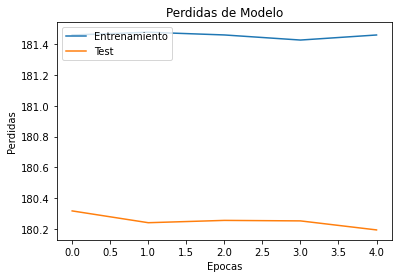

Adam_lr_0.01
Epoch 1/5
871/871 [==============================] - 3s 2ms/step - loss: 0.0344 - mse: 0.0344 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 2/5
871/871 [==============================] - 2s 2ms/step - loss: 0.0352 - mse: 0.0352 - val_loss: 0.0347 - val_mse: 0.0347
Epoch 3/5
871/871 [==============================] - 2s 2ms/step - loss: 0.0353 - mse: 0.0353 - val_loss: 0.0349 - val_mse: 0.0349
Epoch 4/5
871/871 [==============================] - 1s 2ms/step - loss: 0.0353 - mse: 0.0353 - val_loss: 0.0354 - val_mse: 0.0354
Epoch 5/5
69/69 [==============================] - 0s 2ms/step - loss: 0.0347 - mse: 0.0347
[0.034698691219091415, 0.034698691219091415]


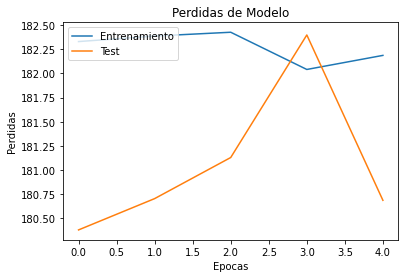

Adam_lr_0.1
Epoch 1/5
871/871 [==============================] - 4s 3ms/step - loss: 0.0365 - mse: 0.0365 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 2/5
871/871 [==============================] - 2s 2ms/step - loss: 0.0377 - mse: 0.0377 - val_loss: 0.0384 - val_mse: 0.0384
Epoch 3/5
871/871 [==============================] - 1s 2ms/step - loss: 0.0378 - mse: 0.0378 - val_loss: 0.0351 - val_mse: 0.0351
Epoch 4/5
871/871 [==============================] - 1s 2ms/step - loss: 0.0362 - mse: 0.0362 - val_loss: 0.0355 - val_mse: 0.0355
Epoch 5/5
69/69 [==============================] - 0s 1ms/step - loss: 0.0360 - mse: 0.0360
[0.036021675914525986, 0.036021675914525986]


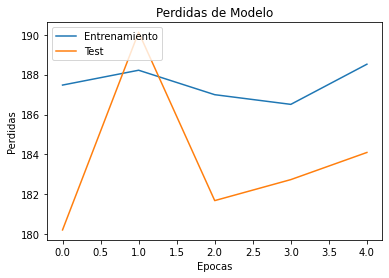

SGD_lr_0.001
Epoch 1/5
871/871 [==============================] - 3s 2ms/step - loss: 0.0341 - mse: 0.0341 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 2/5
871/871 [==============================] - 3s 4ms/step - loss: 0.0342 - mse: 0.0342 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 3/5
871/871 [==============================] - 3s 4ms/step - loss: 0.0347 - mse: 0.0347 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 4/5
871/871 [==============================] - 1s 2ms/step - loss: 0.0342 - mse: 0.0342 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 5/5
69/69 [==============================] - 0s 2ms/step - loss: 0.0346 - mse: 0.0346
[0.03461660444736481, 0.03461660444736481]


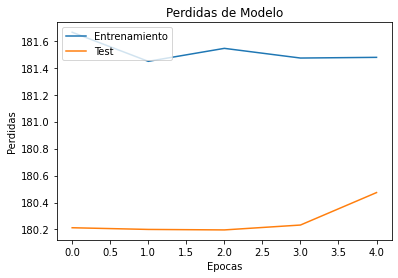

SGD_lr_0.01
Epoch 1/5
871/871 [==============================] - 3s 2ms/step - loss: 0.0349 - mse: 0.0349 - val_loss: 0.0350 - val_mse: 0.0350
Epoch 2/5
871/871 [==============================] - 2s 2ms/step - loss: 0.0342 - mse: 0.0342 - val_loss: 0.0351 - val_mse: 0.0351
Epoch 3/5
871/871 [==============================] - 1s 2ms/step - loss: 0.0356 - mse: 0.0356 - val_loss: 0.0355 - val_mse: 0.0355
Epoch 4/5
871/871 [==============================] - 2s 2ms/step - loss: 0.0357 - mse: 0.0357 - val_loss: 0.0379 - val_mse: 0.0379
Epoch 5/5
69/69 [==============================] - 0s 2ms/step - loss: 0.0345 - mse: 0.0345
[0.03452770411968231, 0.03452770411968231]


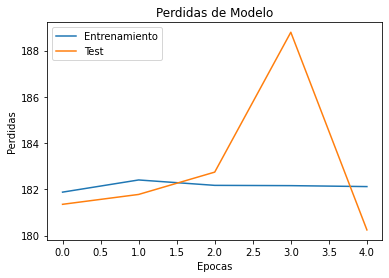

SGD_lr_0.1
Epoch 1/5
871/871 [==============================] - 4s 3ms/step - loss: 0.0362 - mse: 0.0362 - val_loss: 0.0421 - val_mse: 0.0421
Epoch 2/5
871/871 [==============================] - 3s 3ms/step - loss: 0.0366 - mse: 0.0366 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 3/5
871/871 [==============================] - 3s 3ms/step - loss: 0.0361 - mse: 0.0361 - val_loss: 0.0419 - val_mse: 0.0419
Epoch 4/5
871/871 [==============================] - 1s 2ms/step - loss: 0.0365 - mse: 0.0365 - val_loss: 0.0348 - val_mse: 0.0348
Epoch 5/5
69/69 [==============================] - 0s 1ms/step - loss: 0.0381 - mse: 0.0381
[0.038138654083013535, 0.038138654083013535]


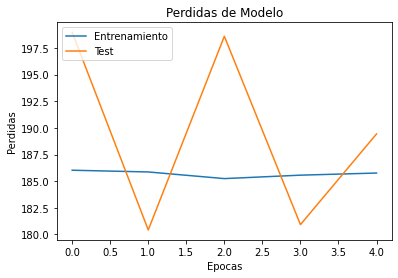

Adam_lr_0.001
Epoch 1/10
871/871 [==============================] - 3s 2ms/step - loss: 0.0353 - mse: 0.0353 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 2/10
871/871 [==============================] - 2s 3ms/step - loss: 0.0343 - mse: 0.0343 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 3/10
871/871 [==============================] - 3s 3ms/step - loss: 0.0349 - mse: 0.0349 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 4/10
871/871 [==============================] - 2s 2ms/step - loss: 0.0348 - mse: 0.0348 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 5/10
871/871 [==============================] - 2s 2ms/step - loss: 0.0367 - mse: 0.0367 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 6/10
871/871 [==============================] - 2s 2ms/step - loss: 0.0342 - mse: 0.0342 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 7/10
871/871 [==============================] - 2s 2ms/step - loss: 0.0353 - mse: 0.0353 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 8/10
871/871 [==============================] - 2s 3ms/s

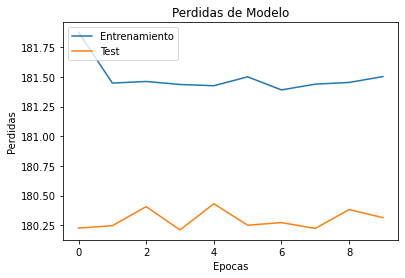

Adam_lr_0.01
Epoch 1/10
871/871 [==============================] - 3s 2ms/step - loss: 0.0355 - mse: 0.0355 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 2/10
871/871 [==============================] - 3s 3ms/step - loss: 0.0349 - mse: 0.0349 - val_loss: 0.0348 - val_mse: 0.0348
Epoch 3/10
871/871 [==============================] - 2s 2ms/step - loss: 0.0351 - mse: 0.0351 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 4/10
871/871 [==============================] - 3s 3ms/step - loss: 0.0355 - mse: 0.0355 - val_loss: 0.0352 - val_mse: 0.0352
Epoch 5/10
871/871 [==============================] - 2s 2ms/step - loss: 0.0344 - mse: 0.0344 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 6/10
871/871 [==============================] - 3s 3ms/step - loss: 0.0345 - mse: 0.0345 - val_loss: 0.0347 - val_mse: 0.0347
Epoch 7/10
871/871 [==============================] - 2s 2ms/step - loss: 0.0340 - mse: 0.0340 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 8/10
871/871 [==============================] - 4s 4ms/st

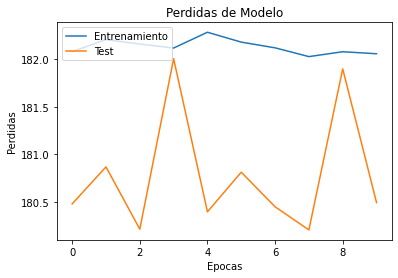

Adam_lr_0.1
Epoch 1/10
871/871 [==============================] - 3s 3ms/step - loss: 0.0380 - mse: 0.0380 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 2/10
871/871 [==============================] - 3s 3ms/step - loss: 0.0378 - mse: 0.0378 - val_loss: 0.0375 - val_mse: 0.0375
Epoch 3/10
871/871 [==============================] - 1s 2ms/step - loss: 0.0373 - mse: 0.0373 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 4/10
871/871 [==============================] - 1s 2ms/step - loss: 0.0380 - mse: 0.0380 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 5/10
871/871 [==============================] - 1s 2ms/step - loss: 0.0367 - mse: 0.0367 - val_loss: 0.0350 - val_mse: 0.0350
Epoch 6/10
871/871 [==============================] - 2s 2ms/step - loss: 0.0375 - mse: 0.0375 - val_loss: 0.0352 - val_mse: 0.0352
Epoch 7/10
871/871 [==============================] - 2s 3ms/step - loss: 0.0373 - mse: 0.0373 - val_loss: 0.0434 - val_mse: 0.0434
Epoch 8/10
871/871 [==============================] - 1s 2ms/ste

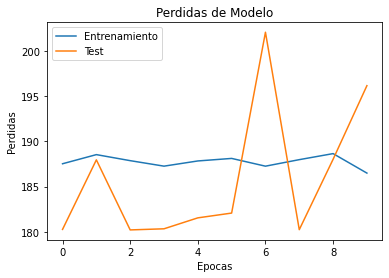

SGD_lr_0.001
Epoch 1/10
871/871 [==============================] - 2s 2ms/step - loss: 0.0355 - mse: 0.0355 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 2/10
871/871 [==============================] - 1s 2ms/step - loss: 0.0344 - mse: 0.0344 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 3/10
871/871 [==============================] - 3s 3ms/step - loss: 0.0338 - mse: 0.0338 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 4/10
871/871 [==============================] - 1s 2ms/step - loss: 0.0355 - mse: 0.0355 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 5/10
871/871 [==============================] - 1s 2ms/step - loss: 0.0343 - mse: 0.0343 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 6/10
871/871 [==============================] - 1s 2ms/step - loss: 0.0338 - mse: 0.0338 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 7/10
871/871 [==============================] - 1s 2ms/step - loss: 0.0355 - mse: 0.0355 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 8/10
871/871 [==============================] - 1s 2ms/st

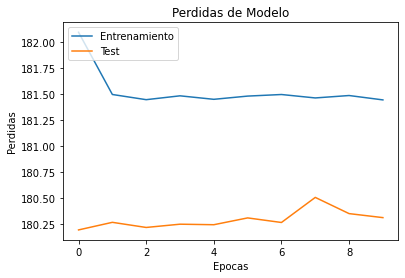

SGD_lr_0.01
Epoch 1/10
871/871 [==============================] - 3s 2ms/step - loss: 0.0351 - mse: 0.0351 - val_loss: 0.0348 - val_mse: 0.0348
Epoch 2/10
871/871 [==============================] - 3s 3ms/step - loss: 0.0346 - mse: 0.0346 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 3/10
871/871 [==============================] - 3s 3ms/step - loss: 0.0346 - mse: 0.0346 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 4/10
871/871 [==============================] - 2s 2ms/step - loss: 0.0344 - mse: 0.0344 - val_loss: 0.0348 - val_mse: 0.0348
Epoch 5/10
871/871 [==============================] - 1s 2ms/step - loss: 0.0369 - mse: 0.0369 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 6/10
871/871 [==============================] - 1s 2ms/step - loss: 0.0355 - mse: 0.0355 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 7/10
871/871 [==============================] - 2s 2ms/step - loss: 0.0359 - mse: 0.0359 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 8/10
871/871 [==============================] - 2s 2ms/ste

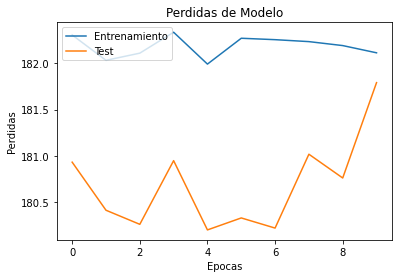

SGD_lr_0.1
Epoch 1/10
871/871 [==============================] - 3s 2ms/step - loss: 0.0371 - mse: 0.0371 - val_loss: 0.0425 - val_mse: 0.0425
Epoch 2/10
871/871 [==============================] - 2s 2ms/step - loss: 0.0371 - mse: 0.0371 - val_loss: 0.0351 - val_mse: 0.0351
Epoch 3/10
871/871 [==============================] - 1s 2ms/step - loss: 0.0365 - mse: 0.0365 - val_loss: 0.0368 - val_mse: 0.0368
Epoch 4/10
871/871 [==============================] - 2s 2ms/step - loss: 0.0367 - mse: 0.0367 - val_loss: 0.0357 - val_mse: 0.0357
Epoch 5/10
871/871 [==============================] - 3s 4ms/step - loss: 0.0371 - mse: 0.0371 - val_loss: 0.0390 - val_mse: 0.0390
Epoch 6/10
871/871 [==============================] - 1s 2ms/step - loss: 0.0373 - mse: 0.0373 - val_loss: 0.0353 - val_mse: 0.0353
Epoch 7/10
871/871 [==============================] - 2s 2ms/step - loss: 0.0363 - mse: 0.0363 - val_loss: 0.0347 - val_mse: 0.0347
Epoch 8/10
871/871 [==============================] - 2s 2ms/step

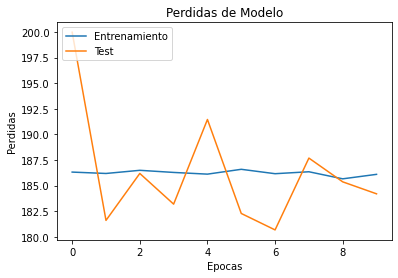

Adam_lr_0.001
Epoch 1/15
871/871 [==============================] - 3s 2ms/step - loss: 0.0348 - mse: 0.0348 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 2/15
871/871 [==============================] - 2s 2ms/step - loss: 0.0360 - mse: 0.0360 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 3/15
871/871 [==============================] - 1s 2ms/step - loss: 0.0342 - mse: 0.0342 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 4/15
871/871 [==============================] - 2s 2ms/step - loss: 0.0344 - mse: 0.0344 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 5/15
871/871 [==============================] - 3s 3ms/step - loss: 0.0344 - mse: 0.0344 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 6/15
871/871 [==============================] - 2s 2ms/step - loss: 0.0359 - mse: 0.0359 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 7/15
871/871 [==============================] - 2s 2ms/step - loss: 0.0346 - mse: 0.0346 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 8/15
871/871 [==============================] - 2s 2ms/s

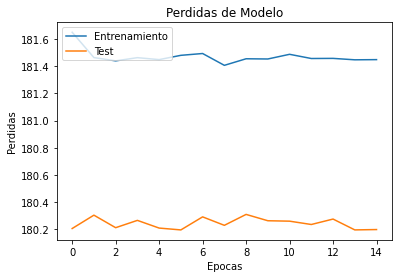

Adam_lr_0.01
Epoch 1/15
871/871 [==============================] - 3s 2ms/step - loss: 0.0356 - mse: 0.0356 - val_loss: 0.0348 - val_mse: 0.0348
Epoch 2/15
871/871 [==============================] - 3s 4ms/step - loss: 0.0344 - mse: 0.0344 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 3/15
871/871 [==============================] - 2s 3ms/step - loss: 0.0352 - mse: 0.0352 - val_loss: 0.0347 - val_mse: 0.0347
Epoch 4/15
871/871 [==============================] - 1s 2ms/step - loss: 0.0350 - mse: 0.0350 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 5/15
871/871 [==============================] - 2s 2ms/step - loss: 0.0354 - mse: 0.0354 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 6/15
871/871 [==============================] - 2s 2ms/step - loss: 0.0347 - mse: 0.0347 - val_loss: 0.0347 - val_mse: 0.0347
Epoch 7/15
871/871 [==============================] - 2s 2ms/step - loss: 0.0351 - mse: 0.0351 - val_loss: 0.0349 - val_mse: 0.0349
Epoch 8/15
871/871 [==============================] - 2s 2ms/st

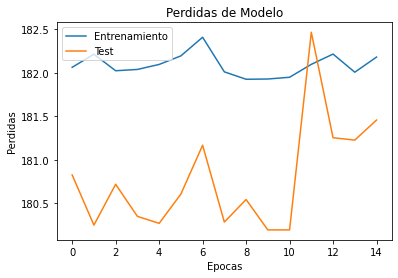

Adam_lr_0.1
Epoch 1/15
871/871 [==============================] - 3s 2ms/step - loss: 0.0375 - mse: 0.0375 - val_loss: 0.0411 - val_mse: 0.0411
Epoch 2/15
871/871 [==============================] - 2s 2ms/step - loss: 0.0374 - mse: 0.0374 - val_loss: 0.0352 - val_mse: 0.0352
Epoch 3/15
871/871 [==============================] - 2s 3ms/step - loss: 0.0388 - mse: 0.0388 - val_loss: 0.0362 - val_mse: 0.0362
Epoch 4/15
871/871 [==============================] - 3s 3ms/step - loss: 0.0382 - mse: 0.0382 - val_loss: 0.0412 - val_mse: 0.0412
Epoch 5/15
871/871 [==============================] - 2s 2ms/step - loss: 0.0384 - mse: 0.0384 - val_loss: 0.0424 - val_mse: 0.0424
Epoch 6/15
871/871 [==============================] - 2s 2ms/step - loss: 0.0371 - mse: 0.0371 - val_loss: 0.0393 - val_mse: 0.0393
Epoch 7/15
871/871 [==============================] - 1s 2ms/step - loss: 0.0378 - mse: 0.0378 - val_loss: 0.0452 - val_mse: 0.0452
Epoch 8/15
871/871 [==============================] - 2s 2ms/ste

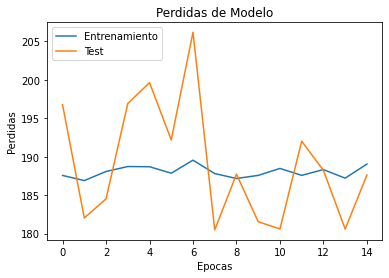

SGD_lr_0.001
Epoch 1/15
871/871 [==============================] - 2s 2ms/step - loss: 0.0353 - mse: 0.0353 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 2/15
871/871 [==============================] - 3s 4ms/step - loss: 0.0340 - mse: 0.0340 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 3/15
871/871 [==============================] - 3s 3ms/step - loss: 0.0343 - mse: 0.0343 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 4/15
871/871 [==============================] - 2s 2ms/step - loss: 0.0349 - mse: 0.0349 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 5/15
871/871 [==============================] - 2s 2ms/step - loss: 0.0352 - mse: 0.0352 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 6/15
871/871 [==============================] - 3s 3ms/step - loss: 0.0362 - mse: 0.0362 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 7/15
871/871 [==============================] - 3s 3ms/step - loss: 0.0345 - mse: 0.0345 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 8/15
871/871 [==============================] - 1s 2ms/st

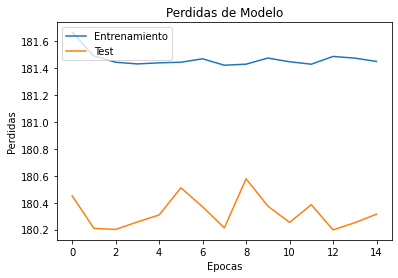

SGD_lr_0.01
Epoch 1/15
871/871 [==============================] - 3s 3ms/step - loss: 0.0368 - mse: 0.0368 - val_loss: 0.0352 - val_mse: 0.0352
Epoch 2/15
871/871 [==============================] - 1s 2ms/step - loss: 0.0363 - mse: 0.0363 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 3/15
871/871 [==============================] - 2s 2ms/step - loss: 0.0357 - mse: 0.0357 - val_loss: 0.0354 - val_mse: 0.0354
Epoch 4/15
871/871 [==============================] - 2s 2ms/step - loss: 0.0357 - mse: 0.0357 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 5/15
871/871 [==============================] - 2s 2ms/step - loss: 0.0351 - mse: 0.0351 - val_loss: 0.0348 - val_mse: 0.0348
Epoch 6/15
871/871 [==============================] - 1s 2ms/step - loss: 0.0357 - mse: 0.0357 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 7/15
871/871 [==============================] - 2s 2ms/step - loss: 0.0351 - mse: 0.0351 - val_loss: 0.0353 - val_mse: 0.0353
Epoch 8/15
871/871 [==============================] - 1s 2ms/ste

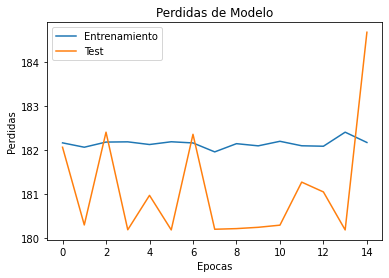

SGD_lr_0.1
Epoch 1/15
871/871 [==============================] - 4s 4ms/step - loss: 0.0374 - mse: 0.0374 - val_loss: 0.0352 - val_mse: 0.0352
Epoch 2/15
871/871 [==============================] - 2s 2ms/step - loss: 0.0371 - mse: 0.0371 - val_loss: 0.0349 - val_mse: 0.0349
Epoch 3/15
871/871 [==============================] - 1s 2ms/step - loss: 0.0368 - mse: 0.0368 - val_loss: 0.0362 - val_mse: 0.0362
Epoch 4/15
871/871 [==============================] - 1s 2ms/step - loss: 0.0354 - mse: 0.0354 - val_loss: 0.0354 - val_mse: 0.0354
Epoch 5/15
871/871 [==============================] - 1s 2ms/step - loss: 0.0367 - mse: 0.0367 - val_loss: 0.0364 - val_mse: 0.0364
Epoch 6/15
871/871 [==============================] - 1s 2ms/step - loss: 0.0377 - mse: 0.0377 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 7/15
871/871 [==============================] - 2s 2ms/step - loss: 0.0363 - mse: 0.0363 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 8/15
871/871 [==============================] - 2s 2ms/step

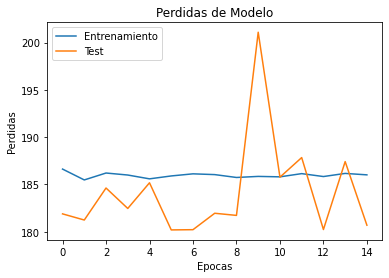

Adam_lr_0.001
Epoch 1/5
175/175 [==============================] - 2s 4ms/step - loss: 0.0346 - mse: 0.0346 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 2/5
175/175 [==============================] - 0s 2ms/step - loss: 0.0349 - mse: 0.0349 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 3/5
175/175 [==============================] - 0s 3ms/step - loss: 0.0347 - mse: 0.0347 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 4/5
175/175 [==============================] - 0s 2ms/step - loss: 0.0351 - mse: 0.0351 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 5/5
69/69 [==============================] - 0s 1ms/step - loss: 0.0345 - mse: 0.0345
[0.034523386508226395, 0.034523386508226395]


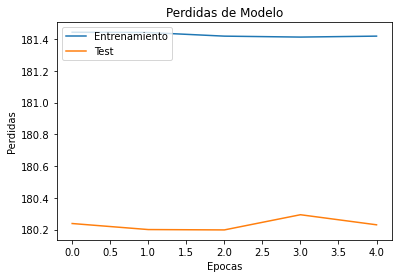

Adam_lr_0.01
Epoch 1/5
175/175 [==============================] - 2s 4ms/step - loss: 0.0352 - mse: 0.0352 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 2/5
175/175 [==============================] - 0s 2ms/step - loss: 0.0348 - mse: 0.0348 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 3/5
175/175 [==============================] - 1s 3ms/step - loss: 0.0348 - mse: 0.0348 - val_loss: 0.0349 - val_mse: 0.0349
Epoch 4/5
175/175 [==============================] - 0s 2ms/step - loss: 0.0343 - mse: 0.0343 - val_loss: 0.0347 - val_mse: 0.0347
Epoch 5/5
69/69 [==============================] - 0s 1ms/step - loss: 0.0347 - mse: 0.0347
[0.034720927476882935, 0.034720927476882935]


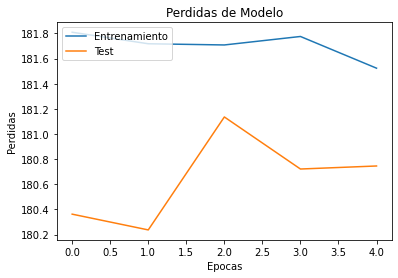

Adam_lr_0.1
Epoch 1/5
175/175 [==============================] - 1s 4ms/step - loss: 0.0371 - mse: 0.0371 - val_loss: 0.0348 - val_mse: 0.0348
Epoch 2/5
175/175 [==============================] - 0s 2ms/step - loss: 0.0366 - mse: 0.0366 - val_loss: 0.0367 - val_mse: 0.0367
Epoch 3/5
175/175 [==============================] - 0s 2ms/step - loss: 0.0359 - mse: 0.0359 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 4/5
175/175 [==============================] - 1s 5ms/step - loss: 0.0371 - mse: 0.0371 - val_loss: 0.0347 - val_mse: 0.0347
Epoch 5/5
69/69 [==============================] - 0s 1ms/step - loss: 0.0391 - mse: 0.0391
[0.039120059460401535, 0.039120059460401535]


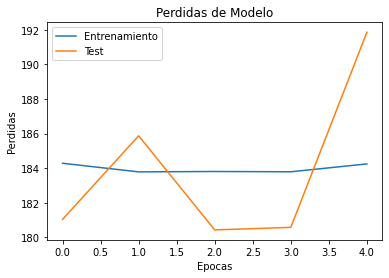

SGD_lr_0.001
Epoch 1/5
175/175 [==============================] - 1s 4ms/step - loss: 0.0373 - mse: 0.0373 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 2/5
175/175 [==============================] - 0s 2ms/step - loss: 0.0354 - mse: 0.0354 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 3/5
175/175 [==============================] - 0s 2ms/step - loss: 0.0342 - mse: 0.0342 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 4/5
175/175 [==============================] - 0s 2ms/step - loss: 0.0360 - mse: 0.0360 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 5/5
69/69 [==============================] - 0s 1ms/step - loss: 0.0345 - mse: 0.0345
[0.03451450541615486, 0.03451450541615486]


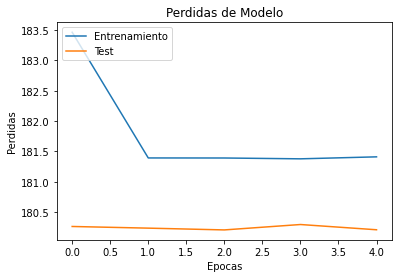

SGD_lr_0.01
Epoch 1/5
175/175 [==============================] - 2s 4ms/step - loss: 0.0366 - mse: 0.0366 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 2/5
175/175 [==============================] - 0s 2ms/step - loss: 0.0351 - mse: 0.0351 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 3/5
175/175 [==============================] - 0s 2ms/step - loss: 0.0348 - mse: 0.0348 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 4/5
175/175 [==============================] - 0s 2ms/step - loss: 0.0345 - mse: 0.0345 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 5/5
69/69 [==============================] - 0s 1ms/step - loss: 0.0345 - mse: 0.0345
[0.03450916334986687, 0.03450916334986687]


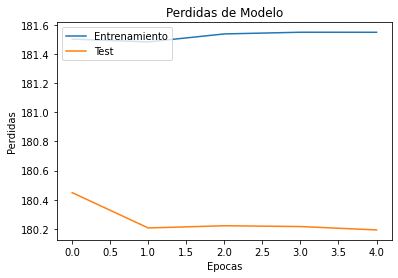

SGD_lr_0.1
Epoch 1/5
175/175 [==============================] - 1s 4ms/step - loss: 0.0355 - mse: 0.0355 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 2/5
175/175 [==============================] - 0s 2ms/step - loss: 0.0354 - mse: 0.0354 - val_loss: 0.0348 - val_mse: 0.0348
Epoch 3/5
175/175 [==============================] - 1s 3ms/step - loss: 0.0359 - mse: 0.0359 - val_loss: 0.0354 - val_mse: 0.0354
Epoch 4/5
175/175 [==============================] - 0s 2ms/step - loss: 0.0361 - mse: 0.0361 - val_loss: 0.0362 - val_mse: 0.0362
Epoch 5/5
69/69 [==============================] - 0s 1ms/step - loss: 0.0345 - mse: 0.0345
[0.03453768044710159, 0.03453768044710159]


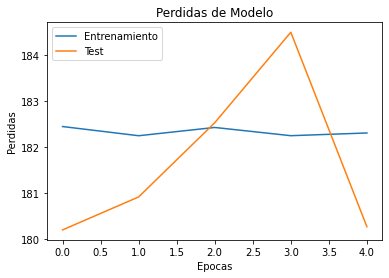

Adam_lr_0.001
Epoch 1/10
175/175 [==============================] - 2s 4ms/step - loss: 0.0353 - mse: 0.0353 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 2/10
175/175 [==============================] - 0s 2ms/step - loss: 0.0356 - mse: 0.0356 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 3/10
175/175 [==============================] - 0s 2ms/step - loss: 0.0347 - mse: 0.0347 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 4/10
175/175 [==============================] - 0s 3ms/step - loss: 0.0349 - mse: 0.0349 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 5/10
175/175 [==============================] - 1s 4ms/step - loss: 0.0361 - mse: 0.0361 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 6/10
175/175 [==============================] - 1s 4ms/step - loss: 0.0353 - mse: 0.0353 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 7/10
175/175 [==============================] - 0s 2ms/step - loss: 0.0362 - mse: 0.0362 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 8/10
175/175 [==============================] - 1s 3ms/s

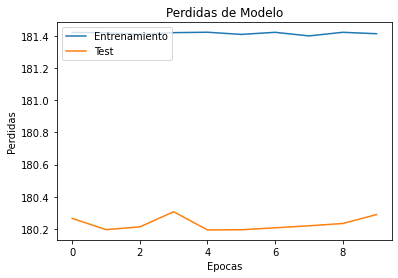

Adam_lr_0.01
Epoch 1/10
175/175 [==============================] - 1s 4ms/step - loss: 0.0351 - mse: 0.0351 - val_loss: 0.0347 - val_mse: 0.0347
Epoch 2/10
175/175 [==============================] - 1s 3ms/step - loss: 0.0345 - mse: 0.0345 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 3/10
175/175 [==============================] - 0s 2ms/step - loss: 0.0348 - mse: 0.0348 - val_loss: 0.0347 - val_mse: 0.0347
Epoch 4/10
175/175 [==============================] - 1s 4ms/step - loss: 0.0356 - mse: 0.0356 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 5/10
175/175 [==============================] - 0s 2ms/step - loss: 0.0358 - mse: 0.0358 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 6/10
175/175 [==============================] - 0s 2ms/step - loss: 0.0353 - mse: 0.0353 - val_loss: 0.0349 - val_mse: 0.0349
Epoch 7/10
175/175 [==============================] - 0s 2ms/step - loss: 0.0351 - mse: 0.0351 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 8/10
175/175 [==============================] - 0s 2ms/st

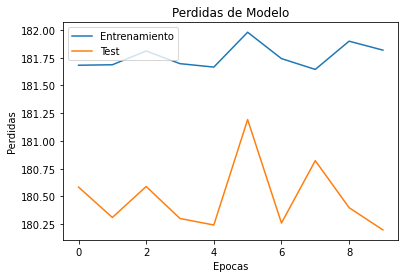

Adam_lr_0.1
Epoch 1/10
175/175 [==============================] - 1s 4ms/step - loss: 0.0353 - mse: 0.0353 - val_loss: 0.0347 - val_mse: 0.0347
Epoch 2/10
175/175 [==============================] - 1s 5ms/step - loss: 0.0349 - mse: 0.0349 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 3/10
175/175 [==============================] - 0s 2ms/step - loss: 0.0372 - mse: 0.0372 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 4/10
175/175 [==============================] - 0s 2ms/step - loss: 0.0352 - mse: 0.0352 - val_loss: 0.0354 - val_mse: 0.0354
Epoch 5/10
175/175 [==============================] - 0s 2ms/step - loss: 0.0352 - mse: 0.0352 - val_loss: 0.0363 - val_mse: 0.0363
Epoch 6/10
175/175 [==============================] - 0s 2ms/step - loss: 0.0361 - mse: 0.0361 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 7/10
175/175 [==============================] - 0s 3ms/step - loss: 0.0356 - mse: 0.0356 - val_loss: 0.0361 - val_mse: 0.0361
Epoch 8/10
175/175 [==============================] - 0s 2ms/ste

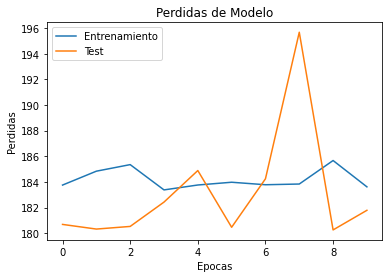

SGD_lr_0.001
Epoch 1/10
175/175 [==============================] - 2s 3ms/step - loss: 0.0354 - mse: 0.0354 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 2/10
175/175 [==============================] - 0s 2ms/step - loss: 0.0353 - mse: 0.0353 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 3/10
175/175 [==============================] - 0s 2ms/step - loss: 0.0354 - mse: 0.0354 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 4/10
175/175 [==============================] - 0s 2ms/step - loss: 0.0356 - mse: 0.0356 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 5/10
175/175 [==============================] - 0s 2ms/step - loss: 0.0349 - mse: 0.0349 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 6/10
175/175 [==============================] - 0s 2ms/step - loss: 0.0341 - mse: 0.0341 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 7/10
175/175 [==============================] - 0s 3ms/step - loss: 0.0349 - mse: 0.0349 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 8/10
175/175 [==============================] - 0s 2ms/st

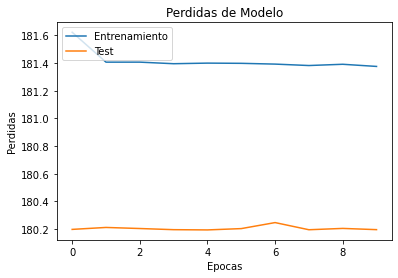

SGD_lr_0.01
Epoch 1/10
175/175 [==============================] - 2s 4ms/step - loss: 0.0346 - mse: 0.0346 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 2/10
175/175 [==============================] - 0s 2ms/step - loss: 0.0347 - mse: 0.0347 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 3/10
175/175 [==============================] - 0s 2ms/step - loss: 0.0350 - mse: 0.0350 - val_loss: 0.0347 - val_mse: 0.0347
Epoch 4/10
175/175 [==============================] - 0s 2ms/step - loss: 0.0353 - mse: 0.0353 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 5/10
175/175 [==============================] - 0s 3ms/step - loss: 0.0348 - mse: 0.0348 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 6/10
175/175 [==============================] - 1s 5ms/step - loss: 0.0347 - mse: 0.0347 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 7/10
175/175 [==============================] - 0s 2ms/step - loss: 0.0353 - mse: 0.0353 - val_loss: 0.0347 - val_mse: 0.0347
Epoch 8/10
175/175 [==============================] - 1s 5ms/ste

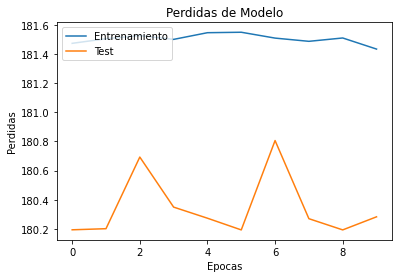

SGD_lr_0.1
Epoch 1/10
175/175 [==============================] - 1s 4ms/step - loss: 0.0354 - mse: 0.0354 - val_loss: 0.0363 - val_mse: 0.0363
Epoch 2/10
175/175 [==============================] - 0s 3ms/step - loss: 0.0348 - mse: 0.0348 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 3/10
175/175 [==============================] - 1s 5ms/step - loss: 0.0343 - mse: 0.0343 - val_loss: 0.0353 - val_mse: 0.0353
Epoch 4/10
175/175 [==============================] - 0s 2ms/step - loss: 0.0350 - mse: 0.0350 - val_loss: 0.0356 - val_mse: 0.0356
Epoch 5/10
175/175 [==============================] - 0s 2ms/step - loss: 0.0361 - mse: 0.0361 - val_loss: 0.0348 - val_mse: 0.0348
Epoch 6/10
175/175 [==============================] - 1s 5ms/step - loss: 0.0350 - mse: 0.0350 - val_loss: 0.0350 - val_mse: 0.0350
Epoch 7/10
175/175 [==============================] - 0s 2ms/step - loss: 0.0359 - mse: 0.0359 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 8/10
175/175 [==============================] - 0s 2ms/step

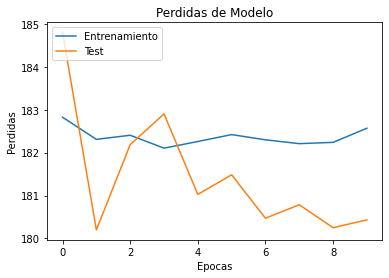

Adam_lr_0.001
Epoch 1/15
175/175 [==============================] - 1s 4ms/step - loss: 0.0349 - mse: 0.0349 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 2/15
175/175 [==============================] - 0s 2ms/step - loss: 0.0347 - mse: 0.0347 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 3/15
175/175 [==============================] - 0s 2ms/step - loss: 0.0353 - mse: 0.0353 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 4/15
175/175 [==============================] - 0s 2ms/step - loss: 0.0349 - mse: 0.0349 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 5/15
175/175 [==============================] - 0s 3ms/step - loss: 0.0343 - mse: 0.0343 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 6/15
175/175 [==============================] - 0s 2ms/step - loss: 0.0351 - mse: 0.0351 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 7/15
175/175 [==============================] - 0s 2ms/step - loss: 0.0352 - mse: 0.0352 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 8/15
175/175 [==============================] - 1s 5ms/s

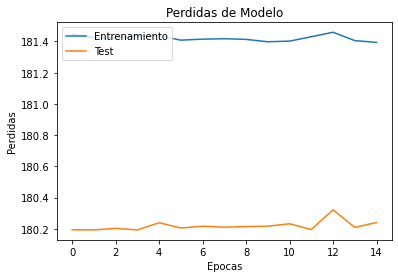

Adam_lr_0.01
Epoch 1/15
175/175 [==============================] - 1s 4ms/step - loss: 0.0348 - mse: 0.0348 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 2/15
175/175 [==============================] - 0s 3ms/step - loss: 0.0355 - mse: 0.0355 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 3/15
175/175 [==============================] - 1s 5ms/step - loss: 0.0331 - mse: 0.0331 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 4/15
175/175 [==============================] - 0s 2ms/step - loss: 0.0344 - mse: 0.0344 - val_loss: 0.0347 - val_mse: 0.0347
Epoch 5/15
175/175 [==============================] - 0s 2ms/step - loss: 0.0341 - mse: 0.0341 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 6/15
175/175 [==============================] - 1s 3ms/step - loss: 0.0344 - mse: 0.0344 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 7/15
175/175 [==============================] - 0s 2ms/step - loss: 0.0353 - mse: 0.0353 - val_loss: 0.0347 - val_mse: 0.0347
Epoch 8/15
175/175 [==============================] - 1s 5ms/st

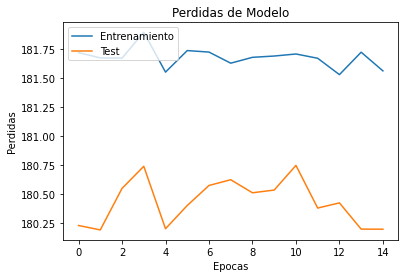

Adam_lr_0.1
Epoch 1/15
175/175 [==============================] - 1s 4ms/step - loss: 0.0345 - mse: 0.0345 - val_loss: 0.0356 - val_mse: 0.0356
Epoch 2/15
175/175 [==============================] - 0s 2ms/step - loss: 0.0365 - mse: 0.0365 - val_loss: 0.0352 - val_mse: 0.0352
Epoch 3/15
175/175 [==============================] - 1s 4ms/step - loss: 0.0368 - mse: 0.0368 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 4/15
175/175 [==============================] - 0s 3ms/step - loss: 0.0376 - mse: 0.0376 - val_loss: 0.0375 - val_mse: 0.0375
Epoch 5/15
175/175 [==============================] - 1s 5ms/step - loss: 0.0355 - mse: 0.0355 - val_loss: 0.0352 - val_mse: 0.0352
Epoch 6/15
175/175 [==============================] - 0s 2ms/step - loss: 0.0361 - mse: 0.0361 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 7/15
175/175 [==============================] - 1s 5ms/step - loss: 0.0357 - mse: 0.0357 - val_loss: 0.0402 - val_mse: 0.0402
Epoch 8/15
175/175 [==============================] - 0s 2ms/ste

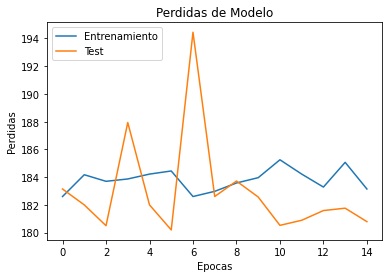

SGD_lr_0.001
Epoch 1/15
175/175 [==============================] - 1s 3ms/step - loss: 0.0349 - mse: 0.0349 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 2/15
175/175 [==============================] - 1s 4ms/step - loss: 0.0348 - mse: 0.0348 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 3/15
175/175 [==============================] - 0s 2ms/step - loss: 0.0347 - mse: 0.0347 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 4/15
175/175 [==============================] - 0s 2ms/step - loss: 0.0342 - mse: 0.0342 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 5/15
175/175 [==============================] - 0s 2ms/step - loss: 0.0350 - mse: 0.0350 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 6/15
175/175 [==============================] - 0s 2ms/step - loss: 0.0344 - mse: 0.0344 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 7/15
175/175 [==============================] - 0s 3ms/step - loss: 0.0355 - mse: 0.0355 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 8/15
175/175 [==============================] - 0s 2ms/st

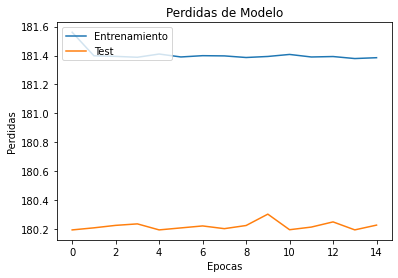

SGD_lr_0.01
Epoch 1/15
175/175 [==============================] - 1s 4ms/step - loss: 0.0349 - mse: 0.0349 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 2/15
175/175 [==============================] - 0s 2ms/step - loss: 0.0348 - mse: 0.0348 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 3/15
175/175 [==============================] - 1s 4ms/step - loss: 0.0337 - mse: 0.0337 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 4/15
175/175 [==============================] - 0s 2ms/step - loss: 0.0356 - mse: 0.0356 - val_loss: 0.0347 - val_mse: 0.0347
Epoch 5/15
175/175 [==============================] - 0s 2ms/step - loss: 0.0354 - mse: 0.0354 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 6/15
175/175 [==============================] - 0s 2ms/step - loss: 0.0349 - mse: 0.0349 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 7/15
175/175 [==============================] - 1s 4ms/step - loss: 0.0352 - mse: 0.0352 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 8/15
175/175 [==============================] - 0s 2ms/ste

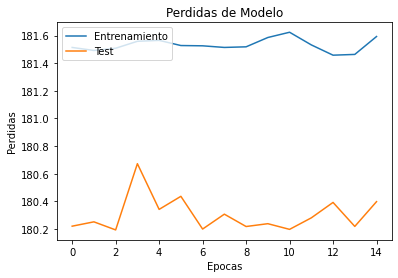

SGD_lr_0.1
Epoch 1/15
175/175 [==============================] - 1s 3ms/step - loss: 0.0355 - mse: 0.0355 - val_loss: 0.0351 - val_mse: 0.0351
Epoch 2/15
175/175 [==============================] - 0s 2ms/step - loss: 0.0372 - mse: 0.0372 - val_loss: 0.0348 - val_mse: 0.0348
Epoch 3/15
175/175 [==============================] - 1s 5ms/step - loss: 0.0358 - mse: 0.0358 - val_loss: 0.0371 - val_mse: 0.0371
Epoch 4/15
175/175 [==============================] - 0s 2ms/step - loss: 0.0353 - mse: 0.0353 - val_loss: 0.0351 - val_mse: 0.0351
Epoch 5/15
175/175 [==============================] - 0s 2ms/step - loss: 0.0353 - mse: 0.0353 - val_loss: 0.0347 - val_mse: 0.0347
Epoch 6/15
175/175 [==============================] - 0s 2ms/step - loss: 0.0360 - mse: 0.0360 - val_loss: 0.0357 - val_mse: 0.0357
Epoch 7/15
175/175 [==============================] - 1s 4ms/step - loss: 0.0355 - mse: 0.0355 - val_loss: 0.0368 - val_mse: 0.0368
Epoch 8/15
175/175 [==============================] - 0s 3ms/step

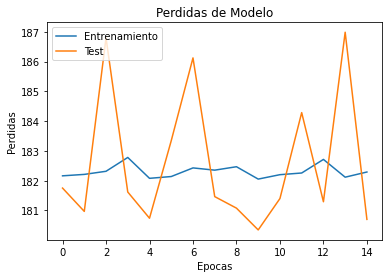

Adam_lr_0.001
Epoch 1/5
88/88 [==============================] - 1s 6ms/step - loss: 0.0358 - mse: 0.0358 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 2/5
88/88 [==============================] - 0s 3ms/step - loss: 0.0369 - mse: 0.0369 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 3/5
88/88 [==============================] - 0s 3ms/step - loss: 0.0354 - mse: 0.0354 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 4/5
88/88 [==============================] - 0s 2ms/step - loss: 0.0348 - mse: 0.0348 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 5/5
69/69 [==============================] - 0s 1ms/step - loss: 0.0345 - mse: 0.0345
[0.03451072424650192, 0.03451072424650192]


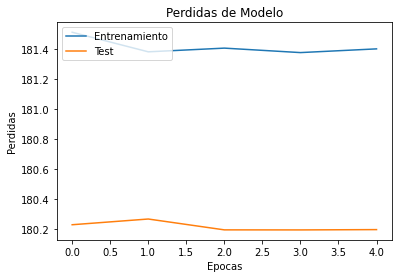

Adam_lr_0.01
Epoch 1/5
88/88 [==============================] - 1s 6ms/step - loss: 0.0342 - mse: 0.0342 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 2/5
88/88 [==============================] - 1s 6ms/step - loss: 0.0351 - mse: 0.0351 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 3/5
88/88 [==============================] - 0s 2ms/step - loss: 0.0355 - mse: 0.0355 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 4/5
88/88 [==============================] - 0s 3ms/step - loss: 0.0332 - mse: 0.0332 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 5/5
69/69 [==============================] - 0s 1ms/step - loss: 0.0347 - mse: 0.0347
[0.03469625115394592, 0.03469625115394592]


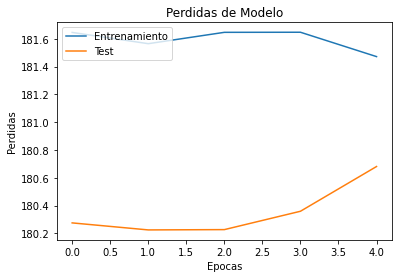

Adam_lr_0.1
Epoch 1/5
88/88 [==============================] - 1s 6ms/step - loss: 0.0363 - mse: 0.0363 - val_loss: 0.0358 - val_mse: 0.0358
Epoch 2/5
88/88 [==============================] - 0s 2ms/step - loss: 0.0354 - mse: 0.0354 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 3/5
88/88 [==============================] - 0s 3ms/step - loss: 0.0354 - mse: 0.0354 - val_loss: 0.0384 - val_mse: 0.0384
Epoch 4/5
88/88 [==============================] - 0s 3ms/step - loss: 0.0367 - mse: 0.0367 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 5/5
69/69 [==============================] - 0s 1ms/step - loss: 0.0371 - mse: 0.0371
[0.03714912757277489, 0.03714912757277489]


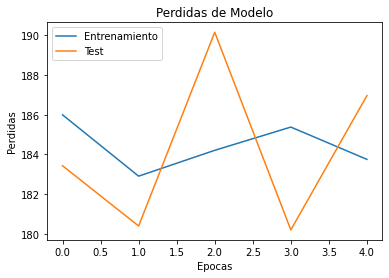

SGD_lr_0.001
Epoch 1/5
88/88 [==============================] - 1s 5ms/step - loss: 0.0358 - mse: 0.0358 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 2/5
88/88 [==============================] - 0s 3ms/step - loss: 0.0351 - mse: 0.0351 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 3/5
88/88 [==============================] - 0s 4ms/step - loss: 0.0351 - mse: 0.0351 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 4/5
88/88 [==============================] - 0s 2ms/step - loss: 0.0338 - mse: 0.0338 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 5/5
69/69 [==============================] - 0s 2ms/step - loss: 0.0345 - mse: 0.0345
[0.034513555467128754, 0.034513555467128754]


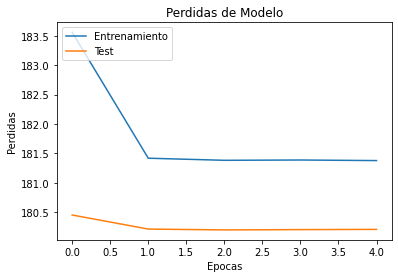

SGD_lr_0.01
Epoch 1/5
88/88 [==============================] - 1s 5ms/step - loss: 0.0355 - mse: 0.0355 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 2/5
88/88 [==============================] - 0s 2ms/step - loss: 0.0344 - mse: 0.0344 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 3/5
88/88 [==============================] - 0s 3ms/step - loss: 0.0348 - mse: 0.0348 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 4/5
88/88 [==============================] - 0s 3ms/step - loss: 0.0346 - mse: 0.0346 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 5/5
69/69 [==============================] - 0s 1ms/step - loss: 0.0345 - mse: 0.0345
[0.034511346369981766, 0.034511346369981766]


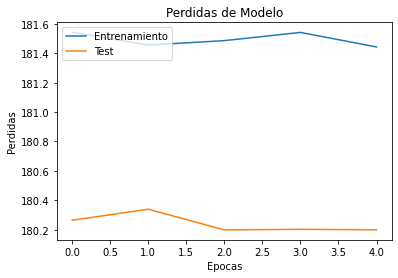

SGD_lr_0.1
Epoch 1/5
88/88 [==============================] - 1s 7ms/step - loss: 0.0356 - mse: 0.0356 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 2/5
88/88 [==============================] - 0s 2ms/step - loss: 0.0355 - mse: 0.0355 - val_loss: 0.0350 - val_mse: 0.0350
Epoch 3/5
88/88 [==============================] - 0s 2ms/step - loss: 0.0359 - mse: 0.0359 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 4/5
88/88 [==============================] - 0s 2ms/step - loss: 0.0350 - mse: 0.0350 - val_loss: 0.0348 - val_mse: 0.0348
Epoch 5/5
69/69 [==============================] - 0s 1ms/step - loss: 0.0382 - mse: 0.0382
[0.03823919966816902, 0.03823919966816902]


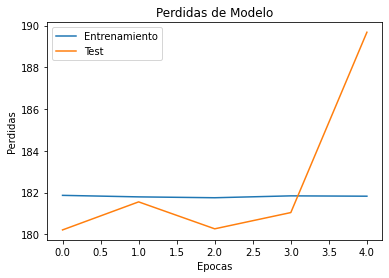

Adam_lr_0.001
Epoch 1/10
88/88 [==============================] - 1s 6ms/step - loss: 0.0376 - mse: 0.0376 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 2/10
88/88 [==============================] - 0s 3ms/step - loss: 0.0339 - mse: 0.0339 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 3/10
88/88 [==============================] - 0s 3ms/step - loss: 0.0356 - mse: 0.0356 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 4/10
88/88 [==============================] - 0s 3ms/step - loss: 0.0351 - mse: 0.0351 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 5/10
88/88 [==============================] - 0s 2ms/step - loss: 0.0355 - mse: 0.0355 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 6/10
88/88 [==============================] - 1s 6ms/step - loss: 0.0353 - mse: 0.0353 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 7/10
88/88 [==============================] - 0s 3ms/step - loss: 0.0344 - mse: 0.0344 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 8/10
88/88 [==============================] - 0s 3ms/step - loss: 0.03

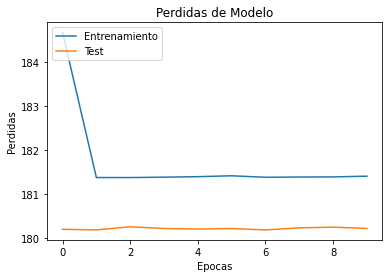

Adam_lr_0.01
Epoch 1/10
88/88 [==============================] - 1s 5ms/step - loss: 0.0352 - mse: 0.0352 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 2/10
88/88 [==============================] - 0s 2ms/step - loss: 0.0358 - mse: 0.0358 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 3/10
88/88 [==============================] - 0s 4ms/step - loss: 0.0343 - mse: 0.0343 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 4/10
88/88 [==============================] - 0s 3ms/step - loss: 0.0351 - mse: 0.0351 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 5/10
88/88 [==============================] - 0s 2ms/step - loss: 0.0337 - mse: 0.0337 - val_loss: 0.0347 - val_mse: 0.0347
Epoch 6/10
88/88 [==============================] - 0s 2ms/step - loss: 0.0350 - mse: 0.0350 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 7/10
88/88 [==============================] - 0s 2ms/step - loss: 0.0351 - mse: 0.0351 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 8/10
88/88 [==============================] - 0s 3ms/step - loss: 0.035

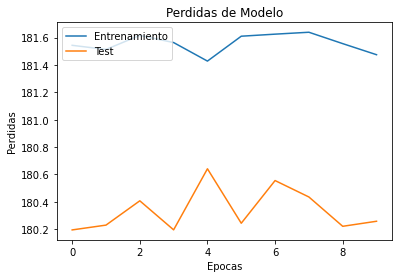

Adam_lr_0.1
Epoch 1/10
88/88 [==============================] - 1s 7ms/step - loss: 0.0347 - mse: 0.0347 - val_loss: 0.0351 - val_mse: 0.0351
Epoch 2/10
88/88 [==============================] - 0s 3ms/step - loss: 0.0363 - mse: 0.0363 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 3/10
88/88 [==============================] - 0s 3ms/step - loss: 0.0359 - mse: 0.0359 - val_loss: 0.0349 - val_mse: 0.0349
Epoch 4/10
88/88 [==============================] - 0s 2ms/step - loss: 0.0354 - mse: 0.0354 - val_loss: 0.0347 - val_mse: 0.0347
Epoch 5/10
88/88 [==============================] - 0s 2ms/step - loss: 0.0359 - mse: 0.0359 - val_loss: 0.0351 - val_mse: 0.0351
Epoch 6/10
88/88 [==============================] - 0s 3ms/step - loss: 0.0353 - mse: 0.0353 - val_loss: 0.0347 - val_mse: 0.0347
Epoch 7/10
88/88 [==============================] - 0s 2ms/step - loss: 0.0350 - mse: 0.0350 - val_loss: 0.0365 - val_mse: 0.0365
Epoch 8/10
88/88 [==============================] - 0s 2ms/step - loss: 0.0368

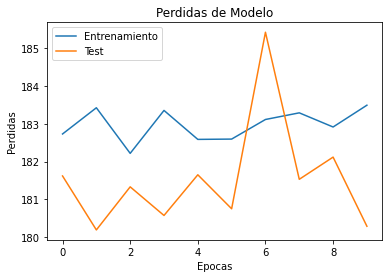

SGD_lr_0.001
Epoch 1/10
88/88 [==============================] - 1s 5ms/step - loss: 0.0354 - mse: 0.0354 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 2/10
88/88 [==============================] - 0s 2ms/step - loss: 0.0338 - mse: 0.0338 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 3/10
88/88 [==============================] - 0s 2ms/step - loss: 0.0349 - mse: 0.0349 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 4/10
88/88 [==============================] - 0s 2ms/step - loss: 0.0358 - mse: 0.0358 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 5/10
88/88 [==============================] - 0s 3ms/step - loss: 0.0346 - mse: 0.0346 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 6/10
88/88 [==============================] - 0s 4ms/step - loss: 0.0350 - mse: 0.0350 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 7/10
88/88 [==============================] - 0s 2ms/step - loss: 0.0349 - mse: 0.0349 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 8/10
88/88 [==============================] - 0s 3ms/step - loss: 0.034

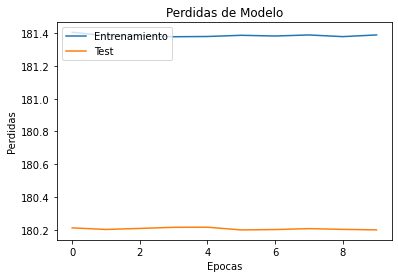

SGD_lr_0.01
Epoch 1/10
88/88 [==============================] - 1s 7ms/step - loss: 0.0350 - mse: 0.0350 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 2/10
88/88 [==============================] - 0s 3ms/step - loss: 0.0350 - mse: 0.0350 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 3/10
88/88 [==============================] - 0s 3ms/step - loss: 0.0341 - mse: 0.0341 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 4/10
88/88 [==============================] - 0s 2ms/step - loss: 0.0340 - mse: 0.0340 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 5/10
88/88 [==============================] - 0s 3ms/step - loss: 0.0352 - mse: 0.0352 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 6/10
88/88 [==============================] - 0s 4ms/step - loss: 0.0342 - mse: 0.0342 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 7/10
88/88 [==============================] - 0s 2ms/step - loss: 0.0352 - mse: 0.0352 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 8/10
88/88 [==============================] - 0s 3ms/step - loss: 0.0358

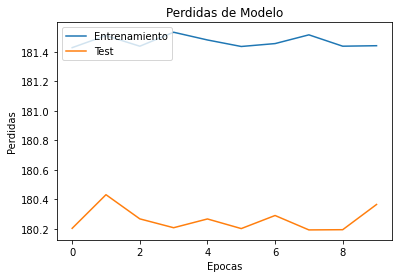

SGD_lr_0.1
Epoch 1/10
88/88 [==============================] - 1s 6ms/step - loss: 0.0346 - mse: 0.0346 - val_loss: 0.0358 - val_mse: 0.0358
Epoch 2/10
88/88 [==============================] - 0s 3ms/step - loss: 0.0356 - mse: 0.0356 - val_loss: 0.0411 - val_mse: 0.0411
Epoch 3/10
88/88 [==============================] - 0s 3ms/step - loss: 0.0368 - mse: 0.0368 - val_loss: 0.0347 - val_mse: 0.0347
Epoch 4/10
88/88 [==============================] - 0s 3ms/step - loss: 0.0351 - mse: 0.0351 - val_loss: 0.0348 - val_mse: 0.0348
Epoch 5/10
88/88 [==============================] - 0s 2ms/step - loss: 0.0347 - mse: 0.0347 - val_loss: 0.0356 - val_mse: 0.0356
Epoch 6/10
88/88 [==============================] - 0s 3ms/step - loss: 0.0350 - mse: 0.0350 - val_loss: 0.0364 - val_mse: 0.0364
Epoch 7/10
88/88 [==============================] - 0s 3ms/step - loss: 0.0355 - mse: 0.0355 - val_loss: 0.0365 - val_mse: 0.0365
Epoch 8/10
88/88 [==============================] - 0s 3ms/step - loss: 0.0350 

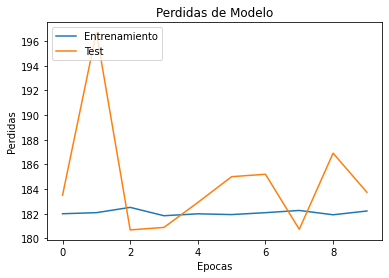

Adam_lr_0.001
Epoch 1/15
88/88 [==============================] - 1s 6ms/step - loss: 0.0365 - mse: 0.0365 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 2/15
88/88 [==============================] - 0s 2ms/step - loss: 0.0357 - mse: 0.0357 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 3/15
88/88 [==============================] - 0s 2ms/step - loss: 0.0347 - mse: 0.0347 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 4/15
88/88 [==============================] - 0s 2ms/step - loss: 0.0356 - mse: 0.0356 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 5/15
88/88 [==============================] - 0s 2ms/step - loss: 0.0351 - mse: 0.0351 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 6/15
88/88 [==============================] - 0s 3ms/step - loss: 0.0353 - mse: 0.0353 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 7/15
88/88 [==============================] - 0s 3ms/step - loss: 0.0351 - mse: 0.0351 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 8/15
88/88 [==============================] - 0s 2ms/step - loss: 0.03

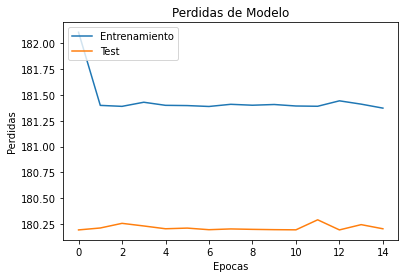

Adam_lr_0.01
Epoch 1/15
88/88 [==============================] - 1s 5ms/step - loss: 0.0356 - mse: 0.0356 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 2/15
88/88 [==============================] - 0s 3ms/step - loss: 0.0349 - mse: 0.0349 - val_loss: 0.0347 - val_mse: 0.0347
Epoch 3/15
88/88 [==============================] - 1s 6ms/step - loss: 0.0350 - mse: 0.0350 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 4/15
88/88 [==============================] - 0s 2ms/step - loss: 0.0335 - mse: 0.0335 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 5/15
88/88 [==============================] - 0s 2ms/step - loss: 0.0352 - mse: 0.0352 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 6/15
88/88 [==============================] - 0s 2ms/step - loss: 0.0356 - mse: 0.0356 - val_loss: 0.0347 - val_mse: 0.0347
Epoch 7/15
88/88 [==============================] - 0s 3ms/step - loss: 0.0348 - mse: 0.0348 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 8/15
88/88 [==============================] - 0s 4ms/step - loss: 0.035

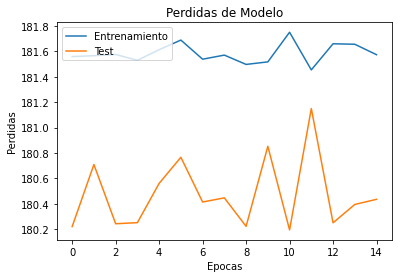

Adam_lr_0.1
Epoch 1/15
88/88 [==============================] - 1s 6ms/step - loss: 0.0371 - mse: 0.0371 - val_loss: 0.0362 - val_mse: 0.0362
Epoch 2/15
88/88 [==============================] - 0s 3ms/step - loss: 0.0359 - mse: 0.0359 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 3/15
88/88 [==============================] - 0s 3ms/step - loss: 0.0359 - mse: 0.0359 - val_loss: 0.0352 - val_mse: 0.0352
Epoch 4/15
88/88 [==============================] - 0s 5ms/step - loss: 0.0360 - mse: 0.0360 - val_loss: 0.0349 - val_mse: 0.0349
Epoch 5/15
88/88 [==============================] - 0s 3ms/step - loss: 0.0349 - mse: 0.0349 - val_loss: 0.0352 - val_mse: 0.0352
Epoch 6/15
88/88 [==============================] - 0s 3ms/step - loss: 0.0361 - mse: 0.0361 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 7/15
88/88 [==============================] - 0s 3ms/step - loss: 0.0349 - mse: 0.0349 - val_loss: 0.0352 - val_mse: 0.0352
Epoch 8/15
88/88 [==============================] - 0s 3ms/step - loss: 0.0360

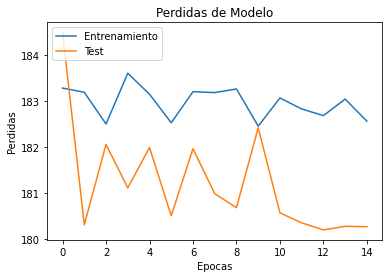

SGD_lr_0.001
Epoch 1/15
88/88 [==============================] - 1s 6ms/step - loss: 0.0360 - mse: 0.0360 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 2/15
88/88 [==============================] - 0s 2ms/step - loss: 0.0343 - mse: 0.0343 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 3/15
88/88 [==============================] - 0s 3ms/step - loss: 0.0337 - mse: 0.0337 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 4/15
88/88 [==============================] - 0s 3ms/step - loss: 0.0343 - mse: 0.0343 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 5/15
88/88 [==============================] - 0s 3ms/step - loss: 0.0352 - mse: 0.0352 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 6/15
88/88 [==============================] - 0s 3ms/step - loss: 0.0342 - mse: 0.0342 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 7/15
88/88 [==============================] - 0s 3ms/step - loss: 0.0351 - mse: 0.0351 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 8/15
88/88 [==============================] - 0s 2ms/step - loss: 0.035

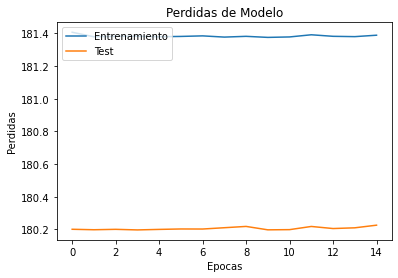

SGD_lr_0.01
Epoch 1/15
88/88 [==============================] - 1s 6ms/step - loss: 0.0359 - mse: 0.0359 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 2/15
88/88 [==============================] - 0s 3ms/step - loss: 0.0346 - mse: 0.0346 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 3/15
88/88 [==============================] - 0s 3ms/step - loss: 0.0340 - mse: 0.0340 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 4/15
88/88 [==============================] - 0s 2ms/step - loss: 0.0355 - mse: 0.0355 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 5/15
88/88 [==============================] - 0s 3ms/step - loss: 0.0357 - mse: 0.0357 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 6/15
88/88 [==============================] - 0s 3ms/step - loss: 0.0344 - mse: 0.0344 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 7/15
88/88 [==============================] - 0s 3ms/step - loss: 0.0351 - mse: 0.0351 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 8/15
88/88 [==============================] - 0s 5ms/step - loss: 0.0346

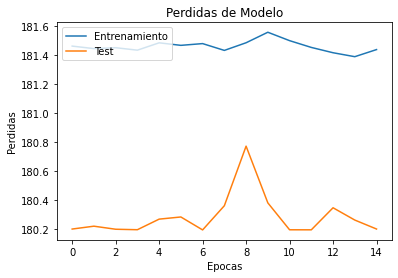

SGD_lr_0.1
Epoch 1/15
88/88 [==============================] - 1s 7ms/step - loss: 0.0351 - mse: 0.0351 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 2/15
88/88 [==============================] - 0s 3ms/step - loss: 0.0339 - mse: 0.0339 - val_loss: 0.0348 - val_mse: 0.0348
Epoch 3/15
88/88 [==============================] - 0s 2ms/step - loss: 0.0348 - mse: 0.0348 - val_loss: 0.0347 - val_mse: 0.0347
Epoch 4/15
88/88 [==============================] - 0s 2ms/step - loss: 0.0345 - mse: 0.0345 - val_loss: 0.0347 - val_mse: 0.0347
Epoch 5/15
88/88 [==============================] - 0s 2ms/step - loss: 0.0352 - mse: 0.0352 - val_loss: 0.0363 - val_mse: 0.0363
Epoch 6/15
88/88 [==============================] - 0s 2ms/step - loss: 0.0356 - mse: 0.0356 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 7/15
88/88 [==============================] - 0s 3ms/step - loss: 0.0355 - mse: 0.0355 - val_loss: 0.0362 - val_mse: 0.0362
Epoch 8/15
88/88 [==============================] - 0s 2ms/step - loss: 0.0355 

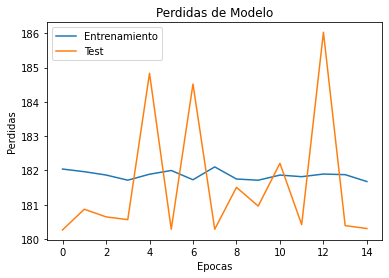

In [127]:
puntuaciones = []

for paquete in batch_size:
    for epoca in epochs:         
        for name, optim in optimizadores:
            print(name)
            print(optim)
            modelo.compile(loss = 'mse', optimizer = optim, metrics=['mse'])
        #     modelo.compile(loss = keras.losses.mse, optimizer = optim, metrics=[tf.keras.metrics.Accuracy()])
            history = modelo.fit(X_train, y_train, batch_size = paquete, epochs = epoca, verbose = 1, validation_data = (X_test, y_test))
            puntuacion = modelo.evaluate(X_test,y_test,verbose=1)
            puntuaciones.append((name, epoca, paquete, puntuacion))
            print(puntuacion)
            plt.figure(1)
            plt.plot(np.sqrt(history.history['loss'])*maximo)
            plt.plot(np.sqrt(history.history['val_loss'])*maximo)
            plt.title('Perdidas de Modelo')
            plt.ylabel('Perdidas')
            plt.xlabel('Epocas')
            plt.legend(['Entrenamiento', 'Test'], loc='upper left')
            plt.show()

In [130]:
punt =pd.DataFrame(puntuaciones, columns = ('name', 'epoca','paquete','loss - mse') )
punt

,name,epoca,paquete,loss - mse
0,Adam_lr_0.001,5,10,"[0.03450970724225044, 0.03450970724225044]"
1,Adam_lr_0.01,5,10,"[0.034698691219091415, 0.034698691219091415]"
2,Adam_lr_0.1,5,10,"[0.036021675914525986, 0.036021675914525986]"
3,SGD_lr_0.001,5,10,"[0.03461660444736481, 0.03461660444736481]"
4,SGD_lr_0.01,5,10,"[0.03452770411968231, 0.03452770411968231]"
5,SGD_lr_0.1,5,10,"[0.038138654083013535, 0.038138654083013535]"
6,Adam_lr_0.001,10,10,"[0.03455567732453346, 0.03455567732453346]"
7,Adam_lr_0.01,10,10,"[0.034624457359313965, 0.034624457359313965]"
8,Adam_lr_0.1,10,10,"[0.040902744978666306, 0.040902744978666306]"
9,SGD_lr_0.001,10,10,"[0.03455463424324989, 0.03455463424324989]"


 Observamos que todo los casos probados las pérdidas son muy grandes lo que viene ha recalcar los resultados que veniamos obteniendo en los modelos anteriores. Además vemos que aunque aumentemos las épocas y el tamaño de los paquetes, la diferencia en las perdidas entre los datos de entrenamiento y los de prueba practicamente son constante como así lo representa las gráficas que ambas se podrían representar como líneas rectas en todos los casos.